# **Deep Generative Models: Variational Autoencoders and Generative Adversarial Networks**

# **CK Dataset**
In the following exercices, you will work with images extracted from the CK dataset: http://www.jeffcohn.net/wp-content/uploads/2020/02/Cohn-Kanade_Database.pdf.pdf

It contains gray-scale images of human faces.

The dataset is provided in the folder `Data/faces/` in `.mat` format. In the following we provide a Dataset class in pytorch to load images from this database.

In [6]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio

from torchvision.utils import make_grid
from math import sqrt
import imageio
import numpy as np
import math
from google.colab import drive

In [15]:
# Mount Google Drive

drive.mount('/content/drive')
%cd "/content/drive/MyDrive/DeepLearning/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DeepLearning


In [28]:
import MyTorchWrapper as mtw
from architectures import GenerativeModel, VAE, GAN


data_path = 'P4/Data'
results_path = 'P4/Results'
output_images_path = results_path + '/images'

save_figure = True  # Whether to save figures or not # FIXME: not used
show_figure = False
num_epochs = 20
plot_every = 10 # During training, plot results every {plot_every} epochs


In [21]:
"""# Our global variables"""
device = mtw.get_torch_device(use_gpu=True, debug=True)
torch.manual_seed(10)
if device == "gpu":
    dataloader_workers = 6 # The amount of processes used to load data in parallel. In case of doubt use 0.
else:
    dataloader_workers = 0
output_resolution = 32
num_val_images = 25

explore_dataset = True
train_vae = True
train_gan = True

Device selected: cuda:0


Create a data loader for the face images dataset

In [11]:
class FacesDB(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self, dataDir=data_path+'/faces/face_ims_64x64.mat', transform=None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.transform = transform

    # What to do to load a single item in the dataset ( read image )
    def __getitem__(self, index):
        data = self.data[:, :, 0, index]
        data = Image.fromarray(data, mode='L')
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None:
            data = self.transform(data)

        # return the image and the label
        return data

    # Return the number of images
    def __len__(self):
        return self.data.shape[3]


Create a `DataLoader` and visualize one image of the dataset

Size of 1 batch of images: torch.Size([256, 1, 64, 64])
Total number of images: 50000


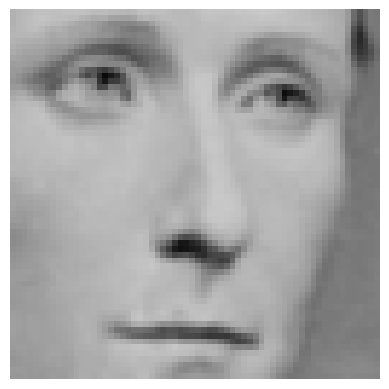

In [16]:
if explore_dataset:
    tr_exploration = transforms.Compose([transforms.ToTensor(), ])
    faces_db = FacesDB(data_path + '/faces/face_ims_64x64.mat', tr_exploration)
    exploration_loader = torch.utils.data.DataLoader(
        dataset=faces_db, batch_size=256, shuffle=True, pin_memory=True)

    # Mini-batch images
    images = next(iter(exploration_loader))
    print("Size of 1 batch of images:", images.shape)
    print("Total number of images:", len(faces_db))
    image = images[0, :, :, :].repeat(3, 1, 1)
    plt.imshow(image.permute(1, 2, 0).squeeze().numpy())
    plt.axis('off')
    plt.show()


In [17]:
tr_training = transforms.Compose([
    transforms.Resize((output_resolution, output_resolution)),
    transforms.ToTensor(),  # convert image to pytorch tensor [0..,1]
    transforms.Normalize((0.5), (0.5)),
])


# Initialize the dataset
train_faces = FacesDB(data_path+'/faces/face_ims_64x64.mat', tr_training)

train_batch_size = math.ceil(len(train_faces) / 20) # TODO: Modify according to PC used
# Class to iterate over the dataset (DataLoader)
train_loader = torch.utils.data.DataLoader(
    dataset=train_faces,
    batch_size = train_batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=dataloader_workers,
)

test_loader = torch.utils.data.DataLoader(
    dataset=train_faces,
    batch_size=num_val_images,
    shuffle=False
)


# Create an IO manager instance to save and load model checkpoints
iomanager = mtw.IOManager(storage_dir=results_path + '/models/') # FIXME: not used

# Ex. 1

1. Following the example of the MNIST, train a VAE with the images we have provided for the CK dataset.

2. For every two epochs during training:

    2.1. Visualize a set of reconstructed images and compute the reconstruction error over the whole dataset

    2.2. Generate and show a set of images from random noise z.

    2.3. Visualize a set of generated images by interpolating over the latent space z.

    2.4 Discuss the different visualizations by analysing their relation with the evolution of the reconstruction loss and the KL regularization term.

In [18]:
def kl_divergence(z_mean, z_log_var):
    kl_loss = 0.5 * torch.sum((torch.exp(z_log_var) + z_mean**2 - 1.0 - z_log_var), axis=1)
    return kl_loss.mean()

def plot_reconstructed_images(vae, test_loader, epoch):
    test_images = next(iter(test_loader))
    test_images = test_images.to(device)
    # Get reconstructed test images with the VAE
    _, z_mean, _ = vae(test_images)
    x_rec = vae.decoder(z_mean)

    figure, axes = plt.subplots(2, 1, figsize=(test_loader.batch_size * 2 + 2, test_loader.batch_size + 1))
    figure.suptitle(f"Reconstructed images at epoch {epoch}", fontsize=14, fontweight="bold")

    image_grid = make_grid(test_images.cpu(), nrow=test_loader.batch_size, padding=1, normalize = True)

    axes[0].imshow(image_grid.permute(1, 2, 0).detach().numpy())
    axes[0].set_title('Original Images')
    axes[0].axis("off")

    axes[1].set_title('Reconstructed Images')
    image_grid = make_grid(x_rec.cpu(), nrow=test_loader.batch_size, padding=1)
    axes[1].imshow(image_grid.permute(1, 2, 0).detach().numpy())
    axes[1].axis("off")

    if save_figure:
        plt.savefig(f"{output_images_path}/{vae.name}/reconstructed_images_e{epoch}.png", dpi=300)

    if not show_figure:
        plt.close()
    plt.show()

def generate_images(model: GenerativeModel, epoch, n_samples=9, device="cpu"):
    ### Generate random samples
    model.eval()
    x_rec = model.sample(n_samples, device)

    # Show synthetic images
    padding = 0
    plt.figure(figsize= (n_samples + padding, n_samples + padding))
    plt.title(f"Generated images at epoch {epoch}", fontsize=14, fontweight="bold")
    image_grid = make_grid(x_rec.cpu(), nrow=math.ceil(sqrt(n_samples)), padding=padding)
    plt.imshow(image_grid.permute(1,2,0).detach().numpy())

    if save_figure:
        plt.savefig(f"{output_images_path}/{model.name}/{model.name}_generated_images_e{epoch}.png", dpi=300)

    if not show_figure:
        plt.close()
    plt.show()

def generate_interpolated(model: GenerativeModel, epoch, n_samples=9, device='cpu'):
    ### Generate random samples
    model.eval()
    n_iterpolations = 50 # Number of intermediate steps between init and final

    # Sample a set of pairs z_init and z_final
    z_init = model.get_latent_space(n_samples=n_samples, device=device)*2
    z_final = model.get_latent_space(n_samples=n_samples, device=device)*2

    # Compute interpolations between z_init and z_final
    # and generate an image for each interpolation.
    interpolation_images = []
    for interp in range(0, n_iterpolations):
        interp_0_1 = float(interp) / (n_iterpolations-1)
        z = z_init * interp_0_1 + z_final * (1 - interp_0_1)
        x_rec = model.decode(z)
        image_grid = make_grid(x_rec.cpu(), nrow=math.ceil(sqrt(n_samples)), padding=1)
        image_grid = image_grid.permute(1, 2, 0).detach().numpy()
        # save the generated images in a list
        interpolation_images.append((image_grid * 255.0).astype(np.uint8))

    # Concatenate the inversion of the list to generate a "loop" animation
    interpolation_images += interpolation_images[::-1]

    # Generate and visualize a give showing the interpolation results.
    imname = f"{output_images_path}/interpolations/{model.name}/ck_e{epoch}.gif"
    fps = 50
    duration = (1000 * 1/fps)
    imageio.mimsave(imname, interpolation_images, duration = duration)

    # with open(imname,'rb') as f:
    #     display(Image(data=f.read(), format='png',width=512,height=512))



In [19]:
def train_VAE(vae: VAE, train_loader, test_loader, optimizer, kl_weight=0.001, num_epochs=10, device='cpu', plot_every=2):
    vae.to(device)
    vae.train()  # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    # Use mean-squared error to compare the original and reconstruct the images
    criterion = nn.MSELoss()

    # Iterate over epochs
    for epoch in range(1, num_epochs + 1):
        # Iterate the dataset
        rec_loss_avg = 0
        kl_loss_avg = 0
        nBatches = 0
        for i, images in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)

            # Forward pass (get encoder variables and reconstructed images)
            x_rec, z_mean, z_log_var = vae(images)

            # Reconstruction loss (x,x_rec)
            reconstruction_loss = criterion(x_rec, images)
            # Compute KL divergecnes KL( N(mu_x,sigma_x) || N(0,I))
            kl_loss = kl_divergence(z_mean, z_log_var)

            # Backward and optimize reconstruction loss and kl regularization
            optimizer.zero_grad()
            # we use a weight to balance the importance of the KL loss
            loss = reconstruction_loss + kl_loss * kl_weight
            loss.backward()
            optimizer.step()

            rec_loss_avg += reconstruction_loss.cpu().item()
            kl_loss_avg += kl_loss.cpu().item()

            nBatches += 1
            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Rec. Loss: {:.4f}, KL Loss: {:.4f}'
                      .format(epoch, num_epochs, i+1, total_step, rec_loss_avg / nBatches, kl_loss_avg / nBatches))

        # Visualize the images every two training epochs
        if epoch % plot_every == 0:
            plot_reconstructed_images(vae, test_loader, epoch)
            generate_images(vae, epoch, n_samples=test_loader.batch_size, device=device)
            generate_interpolated(vae, epoch, n_samples=test_loader.batch_size, device=device)

        print('Epoch [{}/{}], Step [{}/{}], Rec. Loss: {:.4f}, KL Loss: {:.4f}'
              .format(epoch, num_epochs, i + 1, total_step, rec_loss_avg / nBatches, kl_loss_avg / nBatches))
        losses_list.append(rec_loss_avg / nBatches)
        # save trained model
        torch.save(vae.state_dict(), f"{results_path}/{vae.name}_ck.ckpt")

    return losses_list

#################### Training VAE ####################
Epoch [1/10], Step [20/20], Rec. Loss: 0.2018, KL Loss: 14.7124


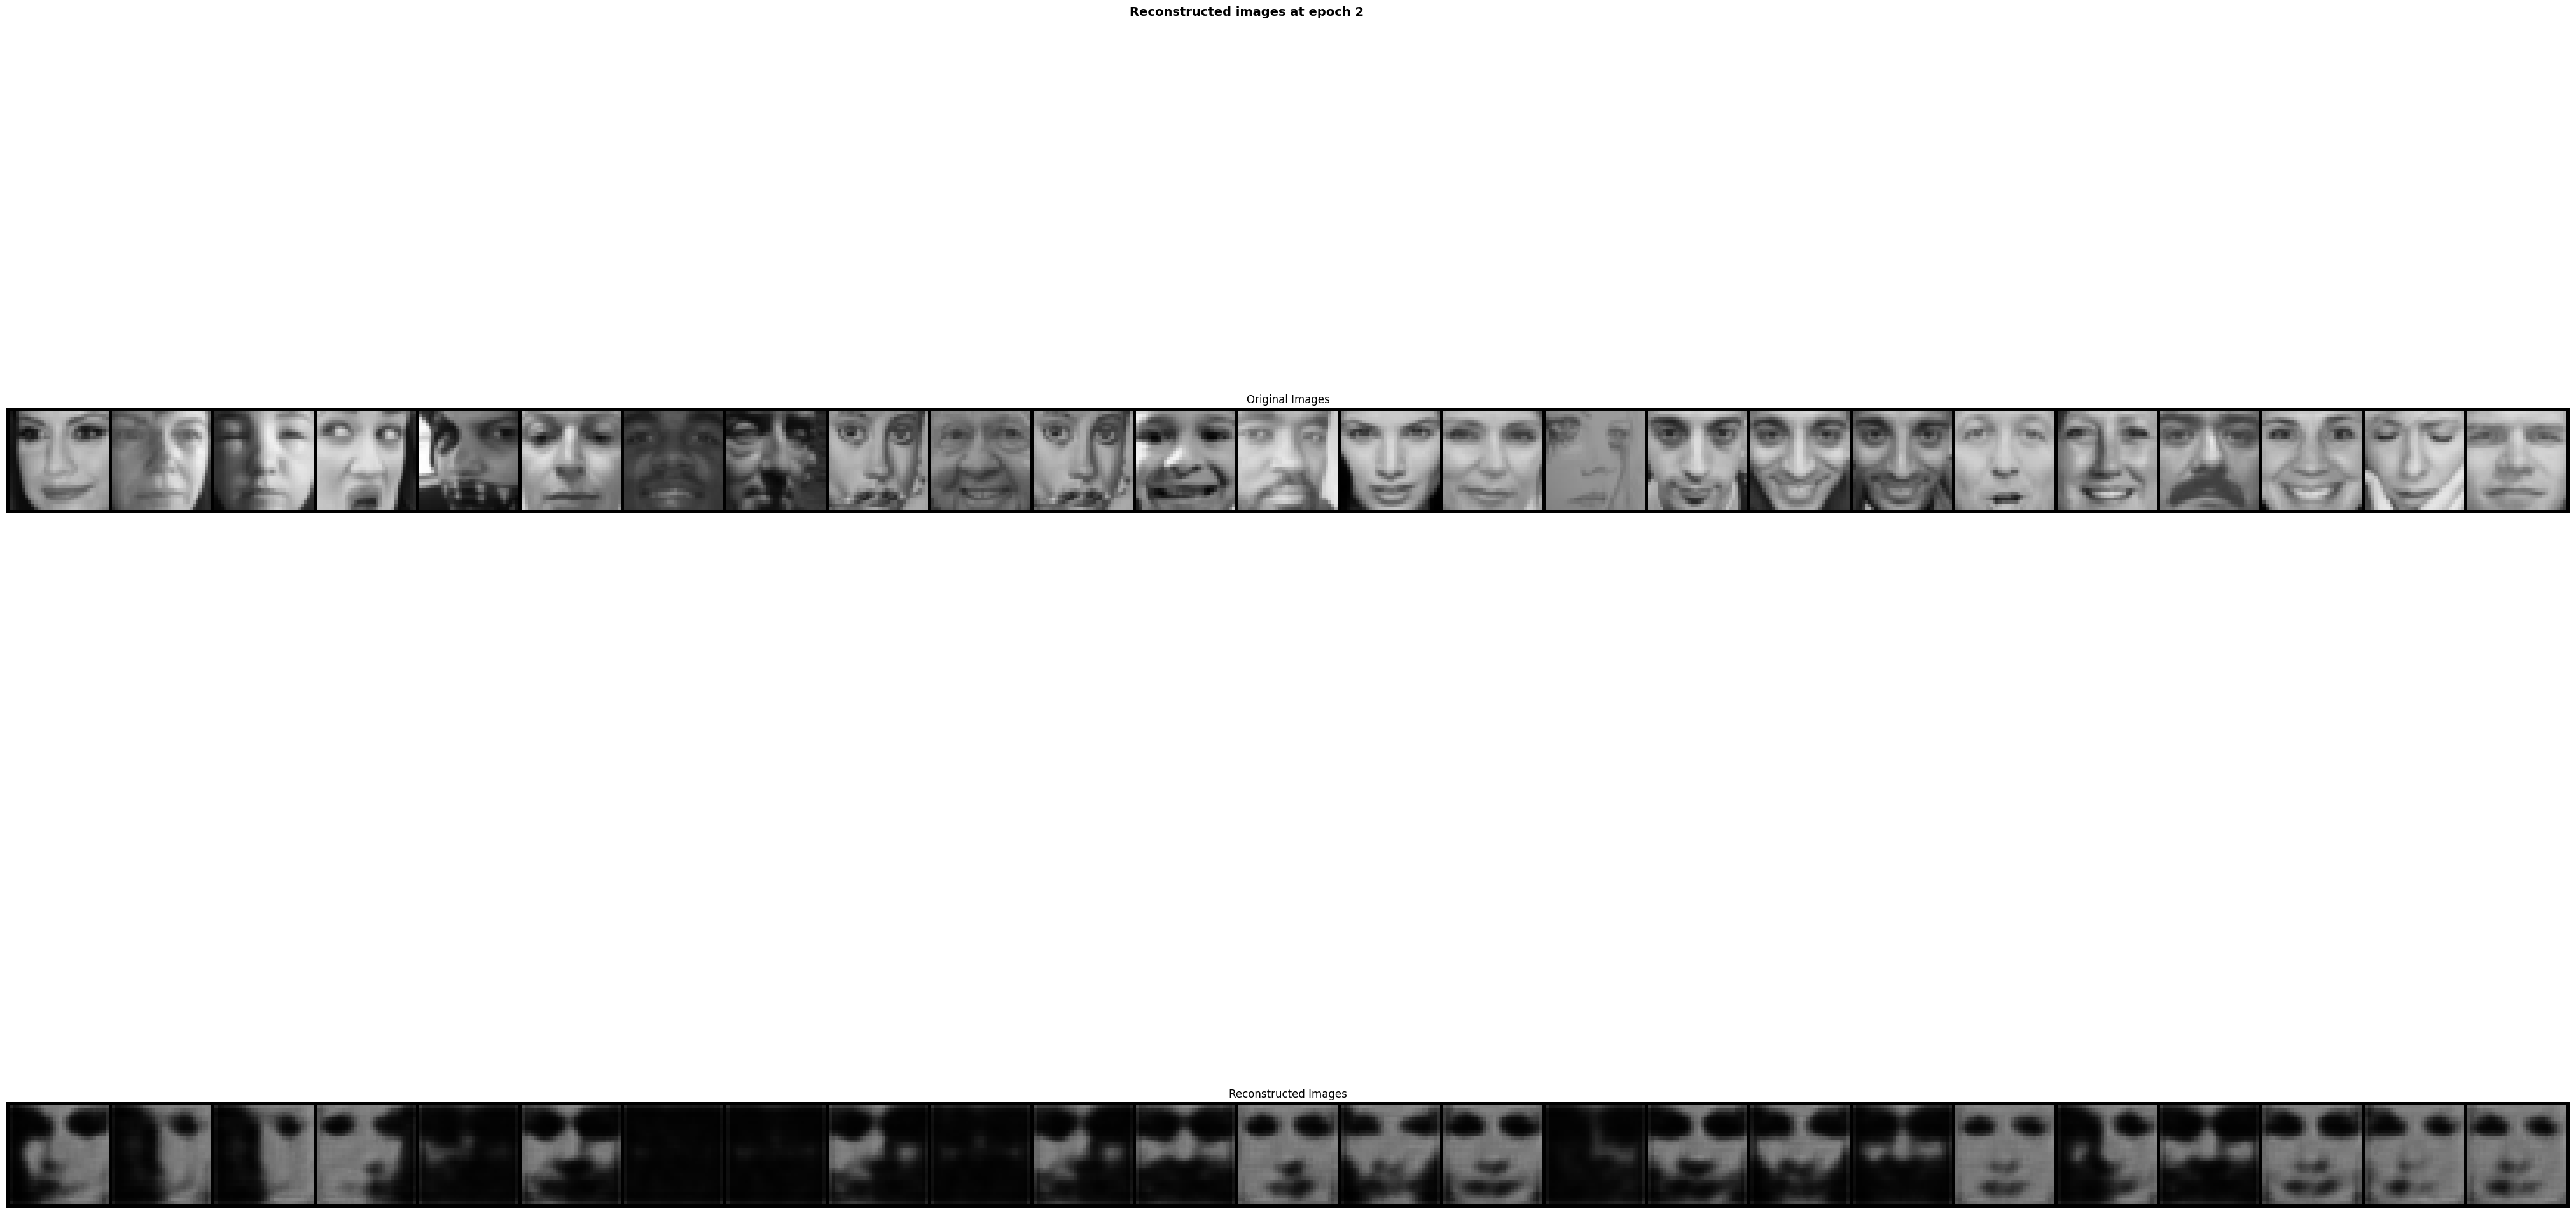

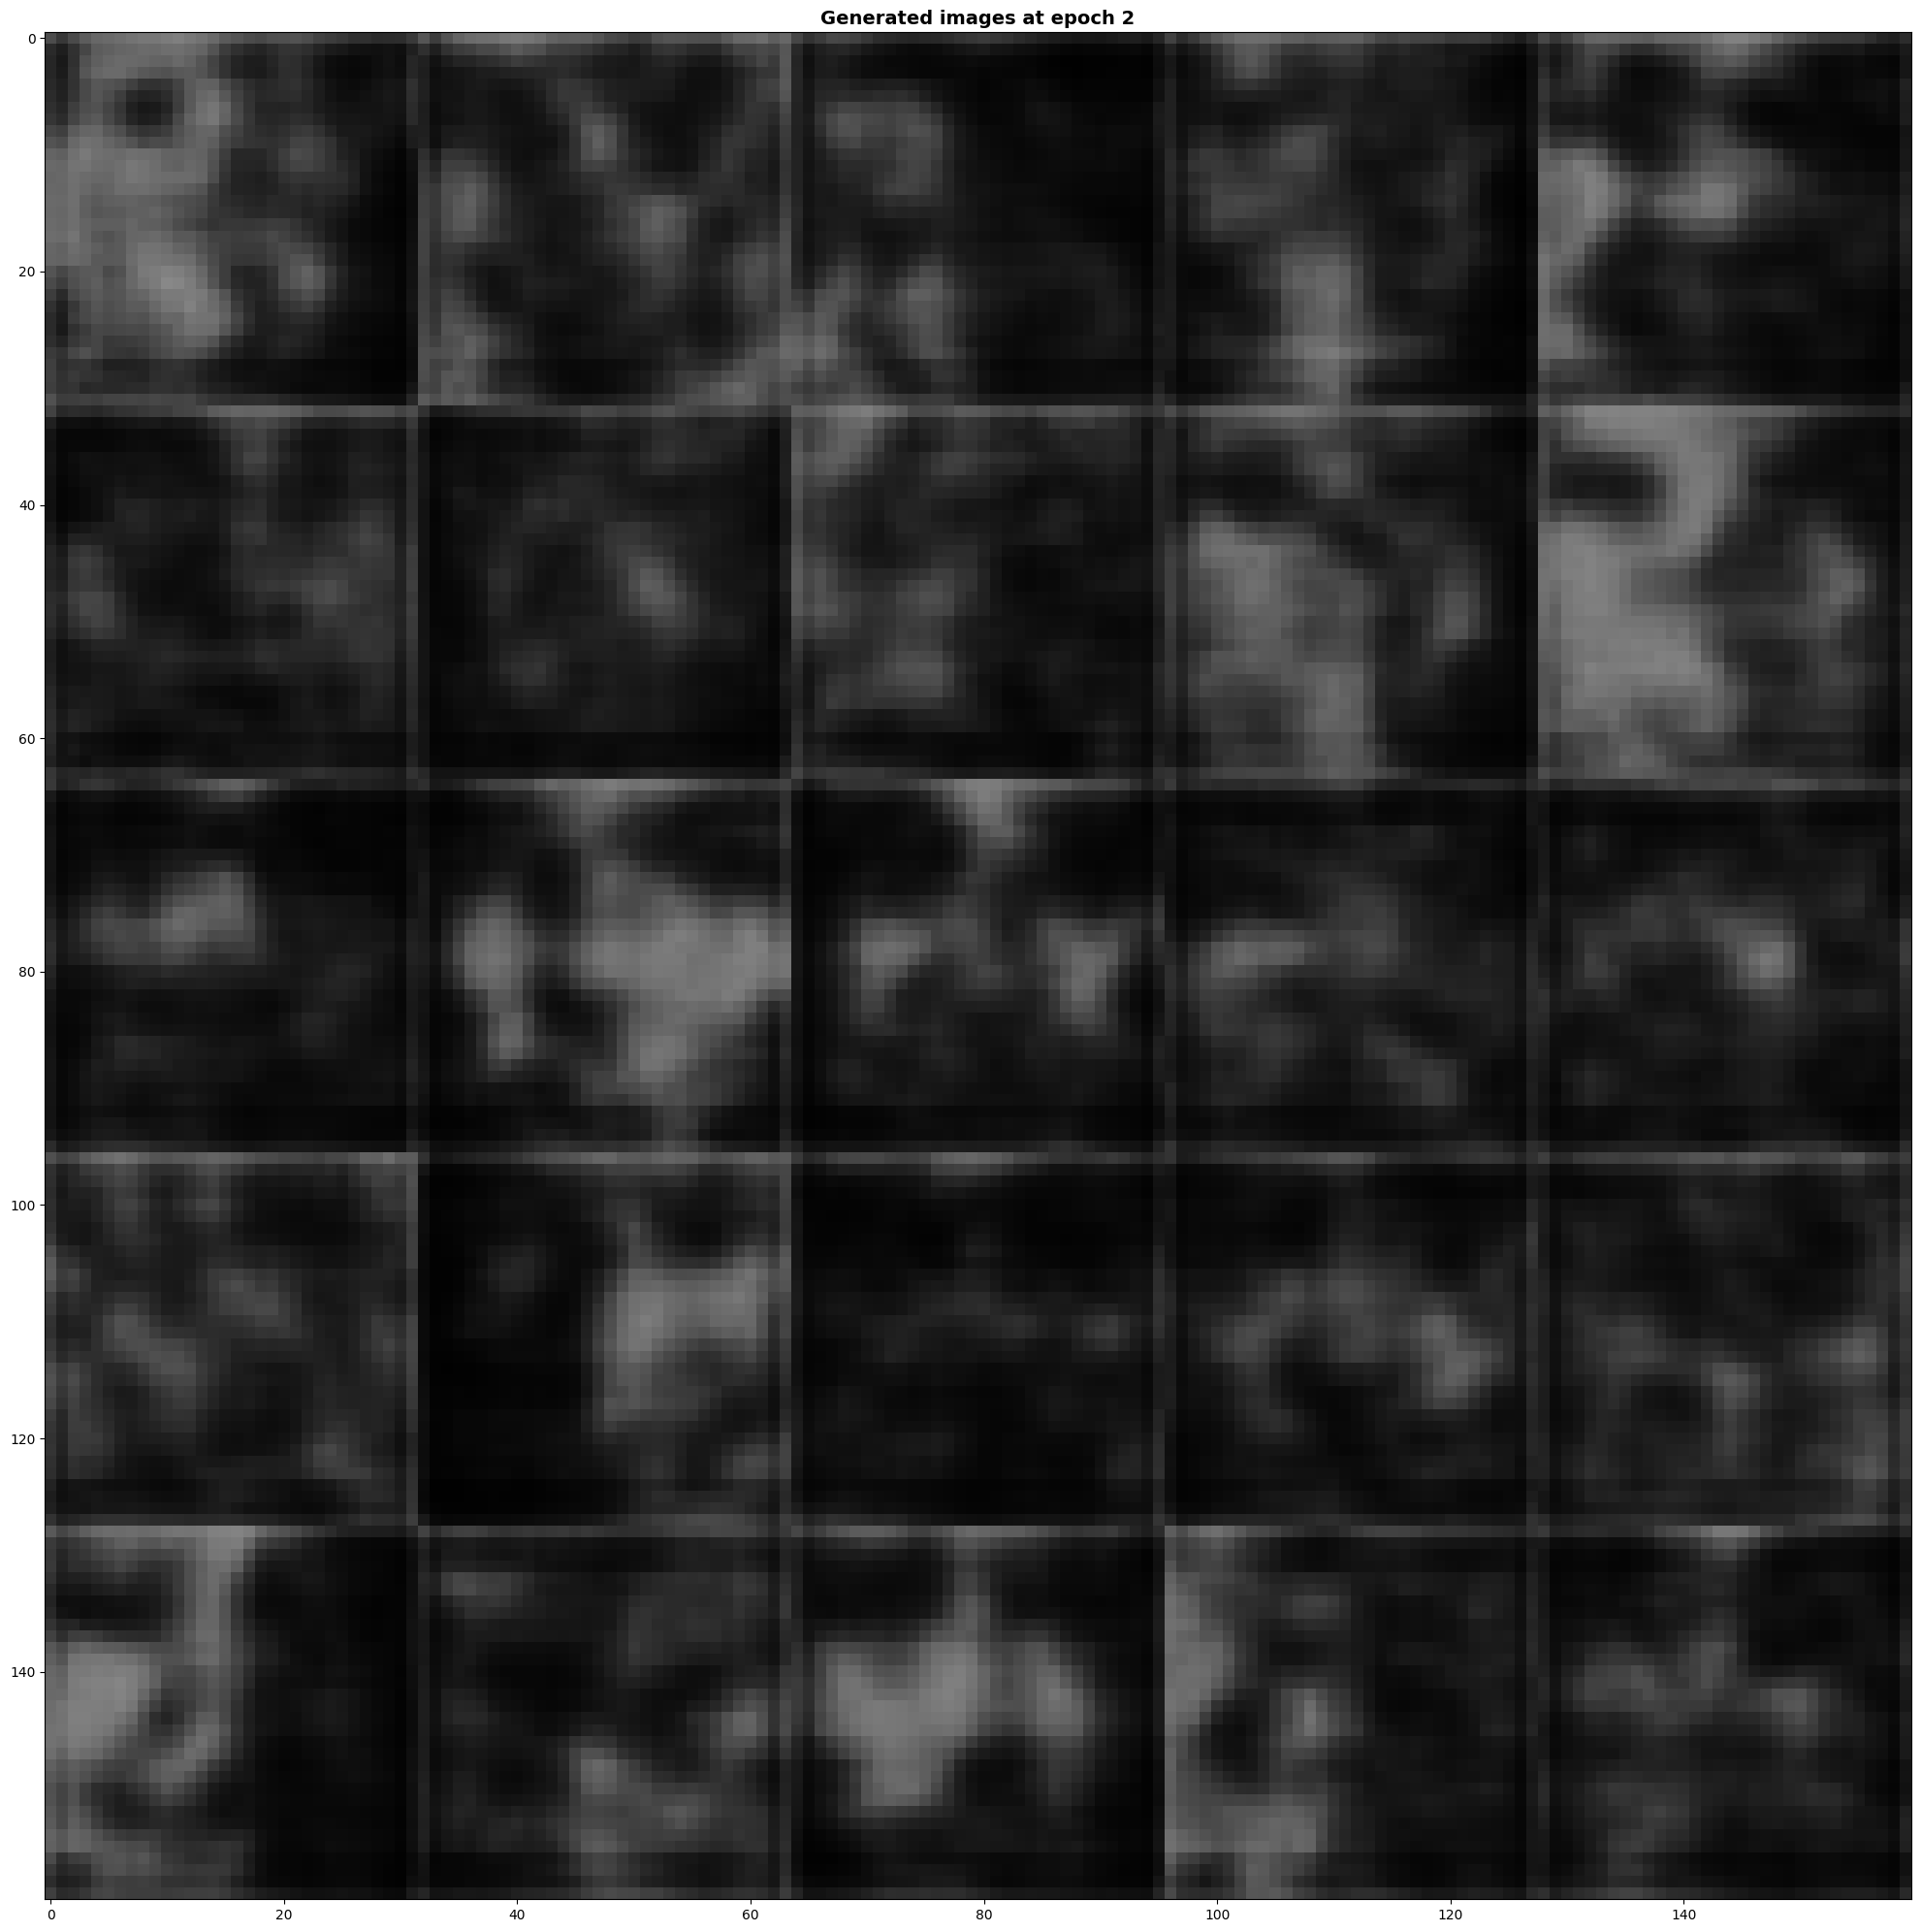

Epoch [2/10], Step [20/20], Rec. Loss: 0.1232, KL Loss: 10.0967
Epoch [3/10], Step [20/20], Rec. Loss: 0.1092, KL Loss: 9.3627


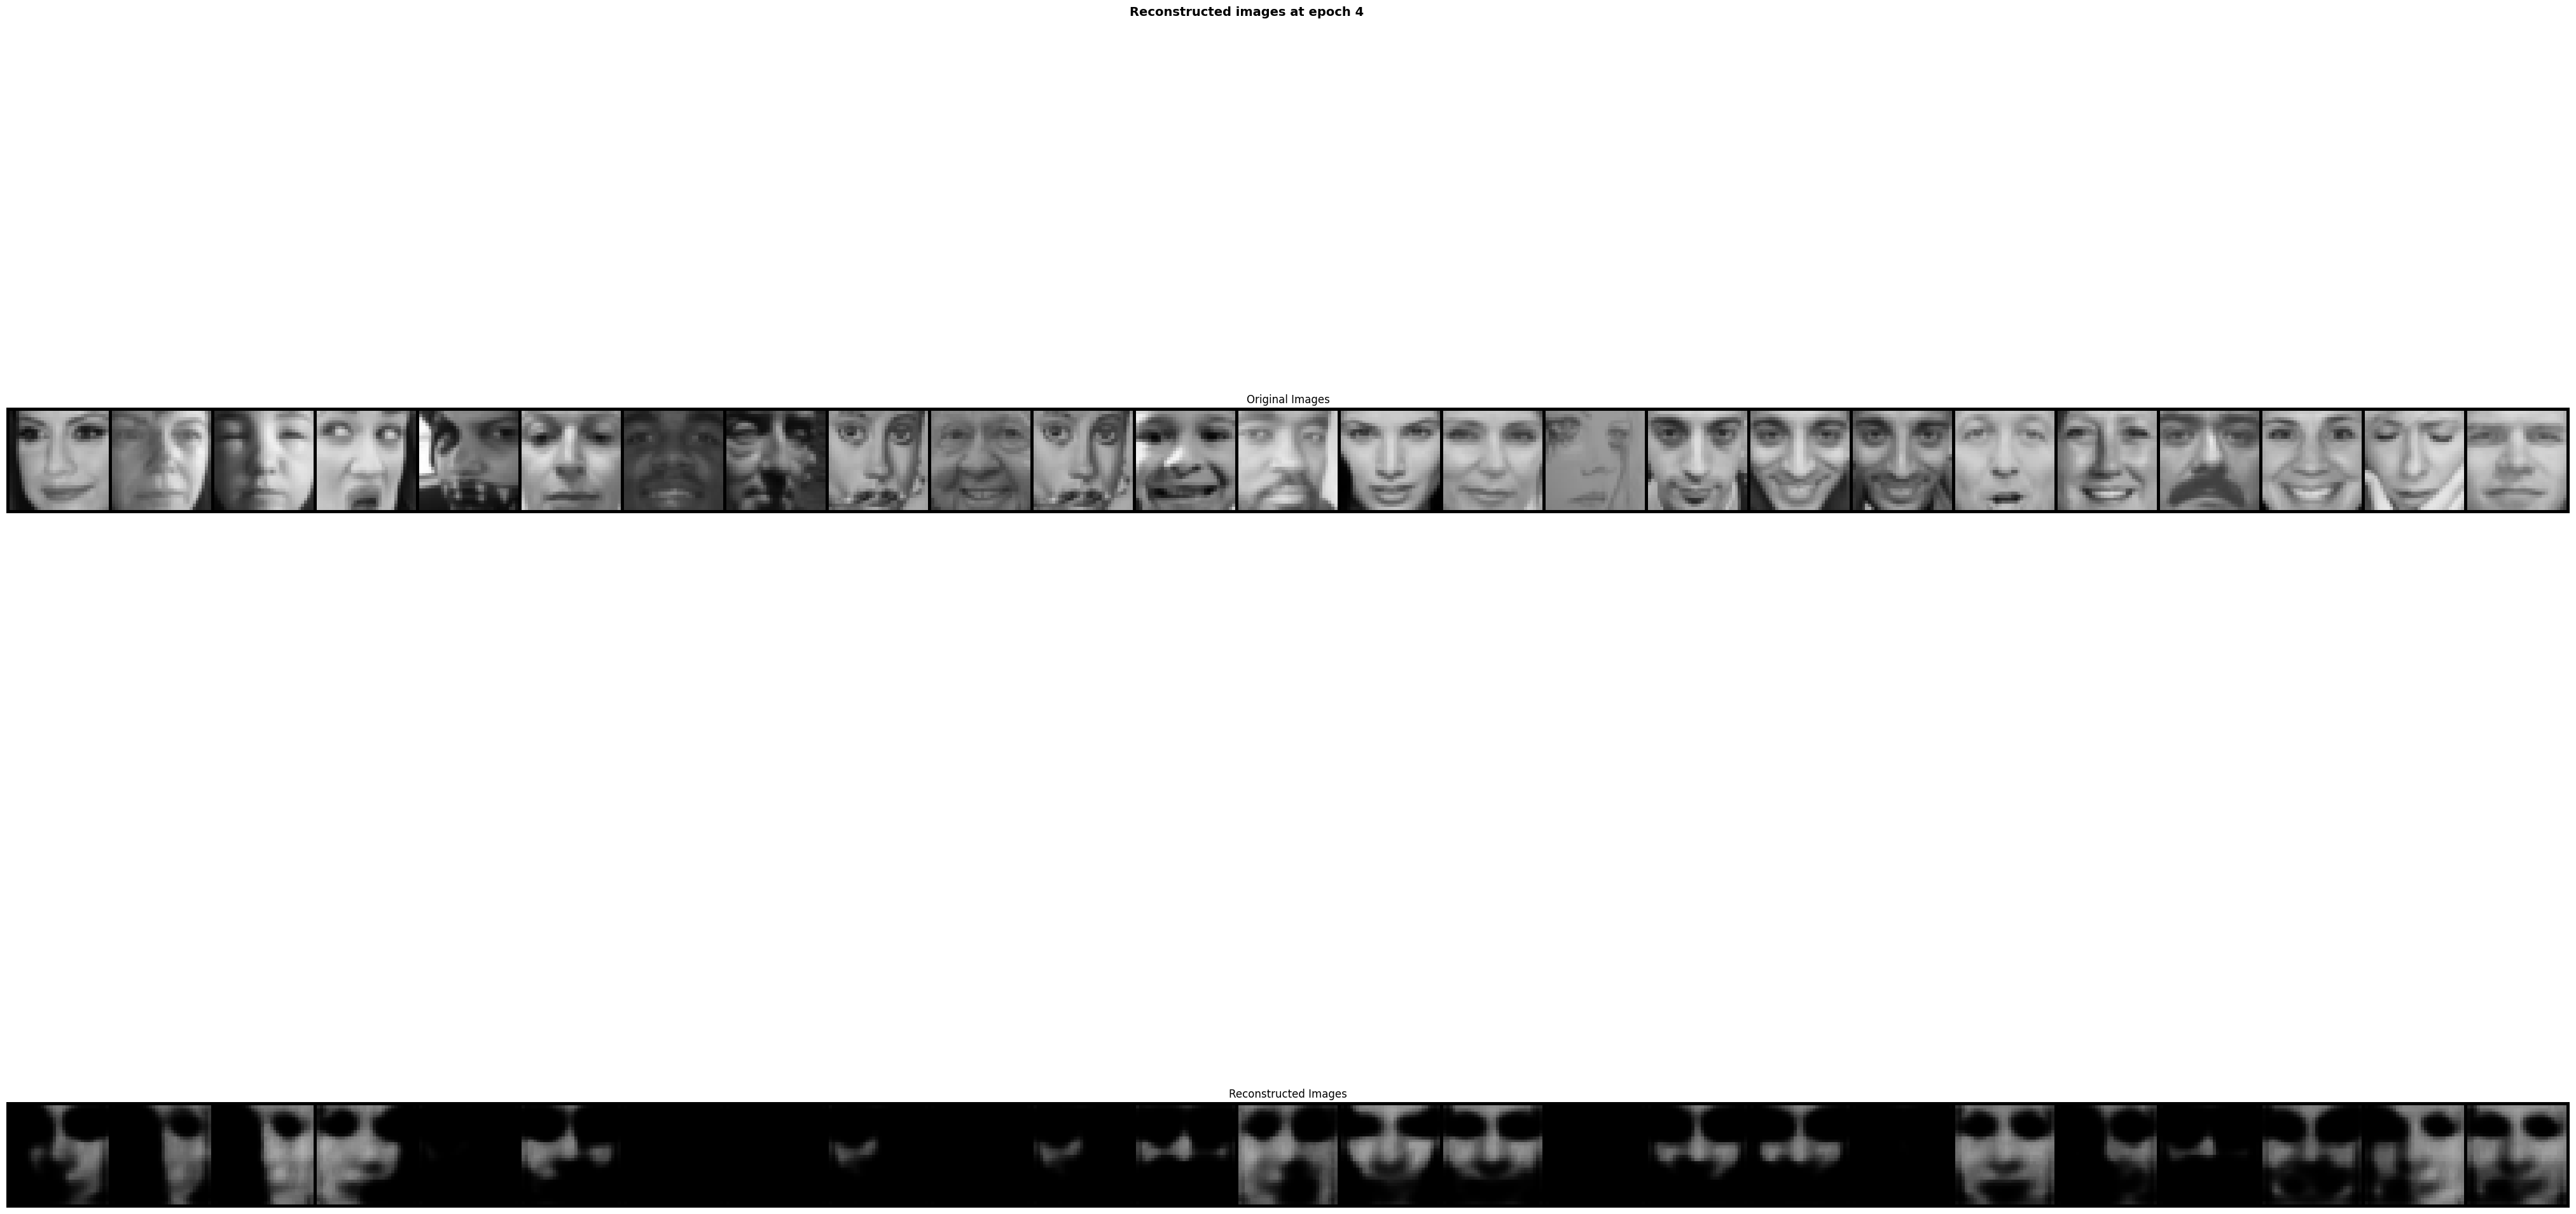

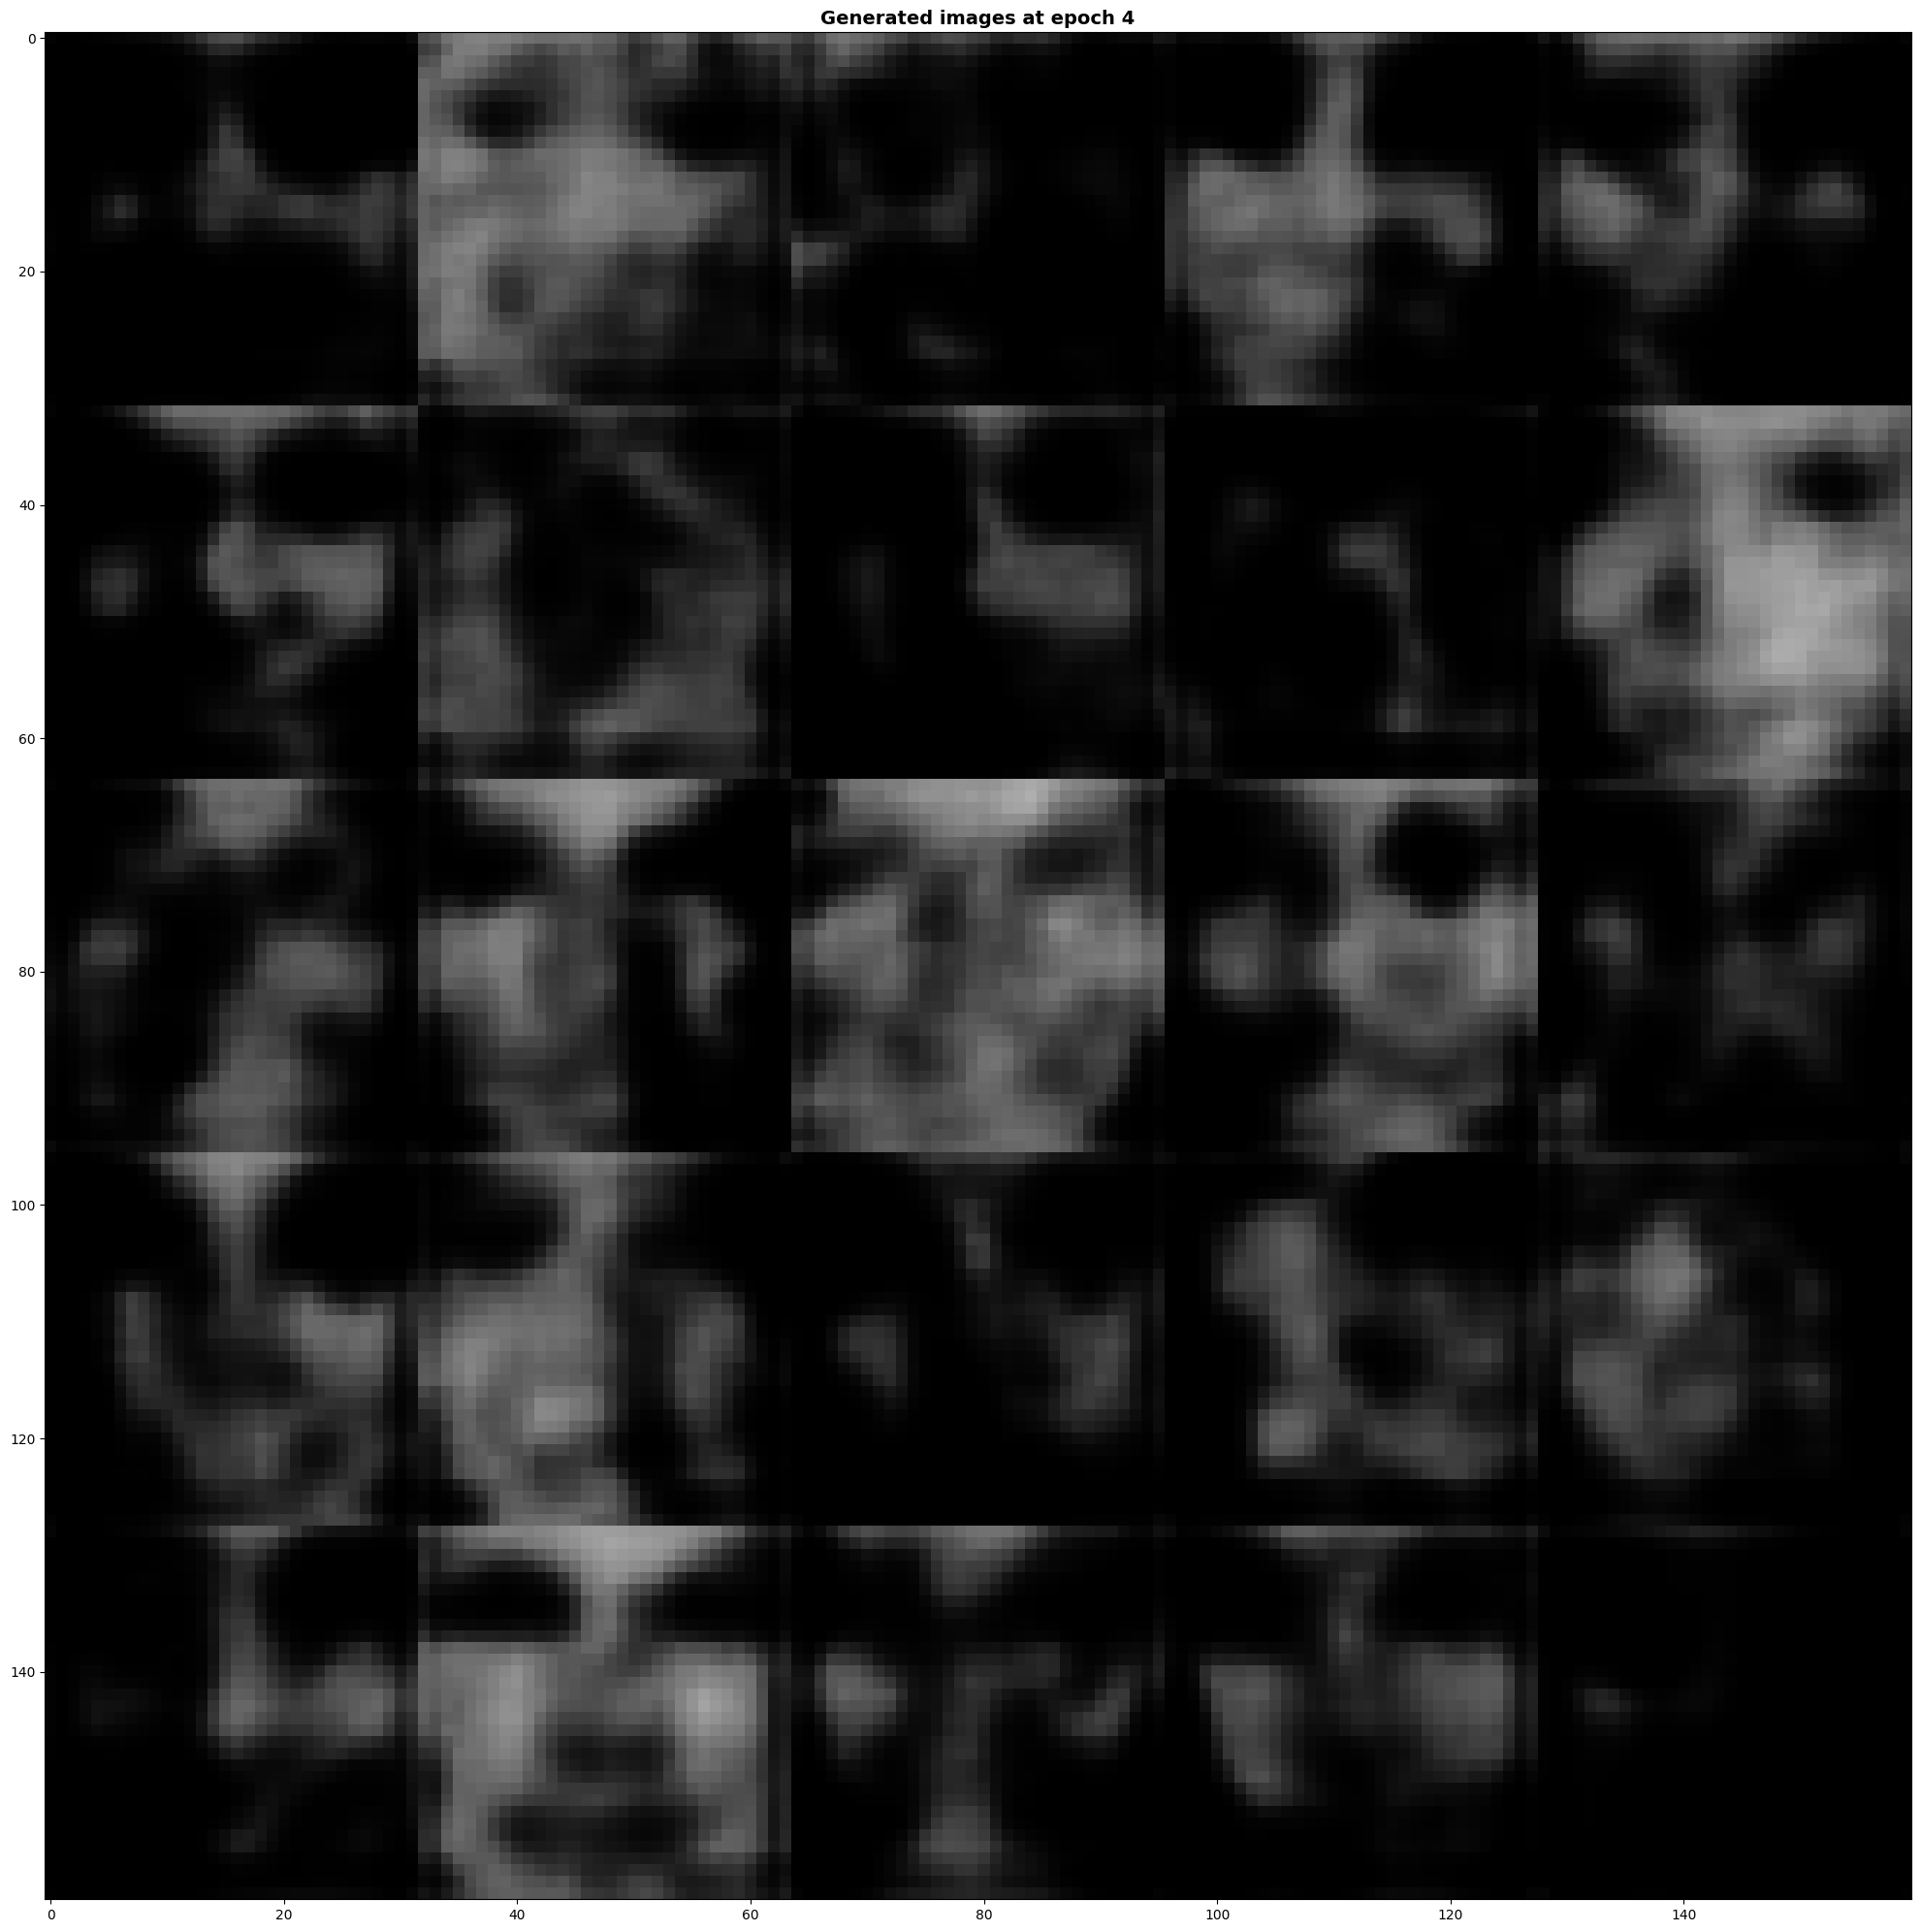

Epoch [4/10], Step [20/20], Rec. Loss: 0.1003, KL Loss: 8.9464
Epoch [5/10], Step [20/20], Rec. Loss: 0.0974, KL Loss: 9.2020


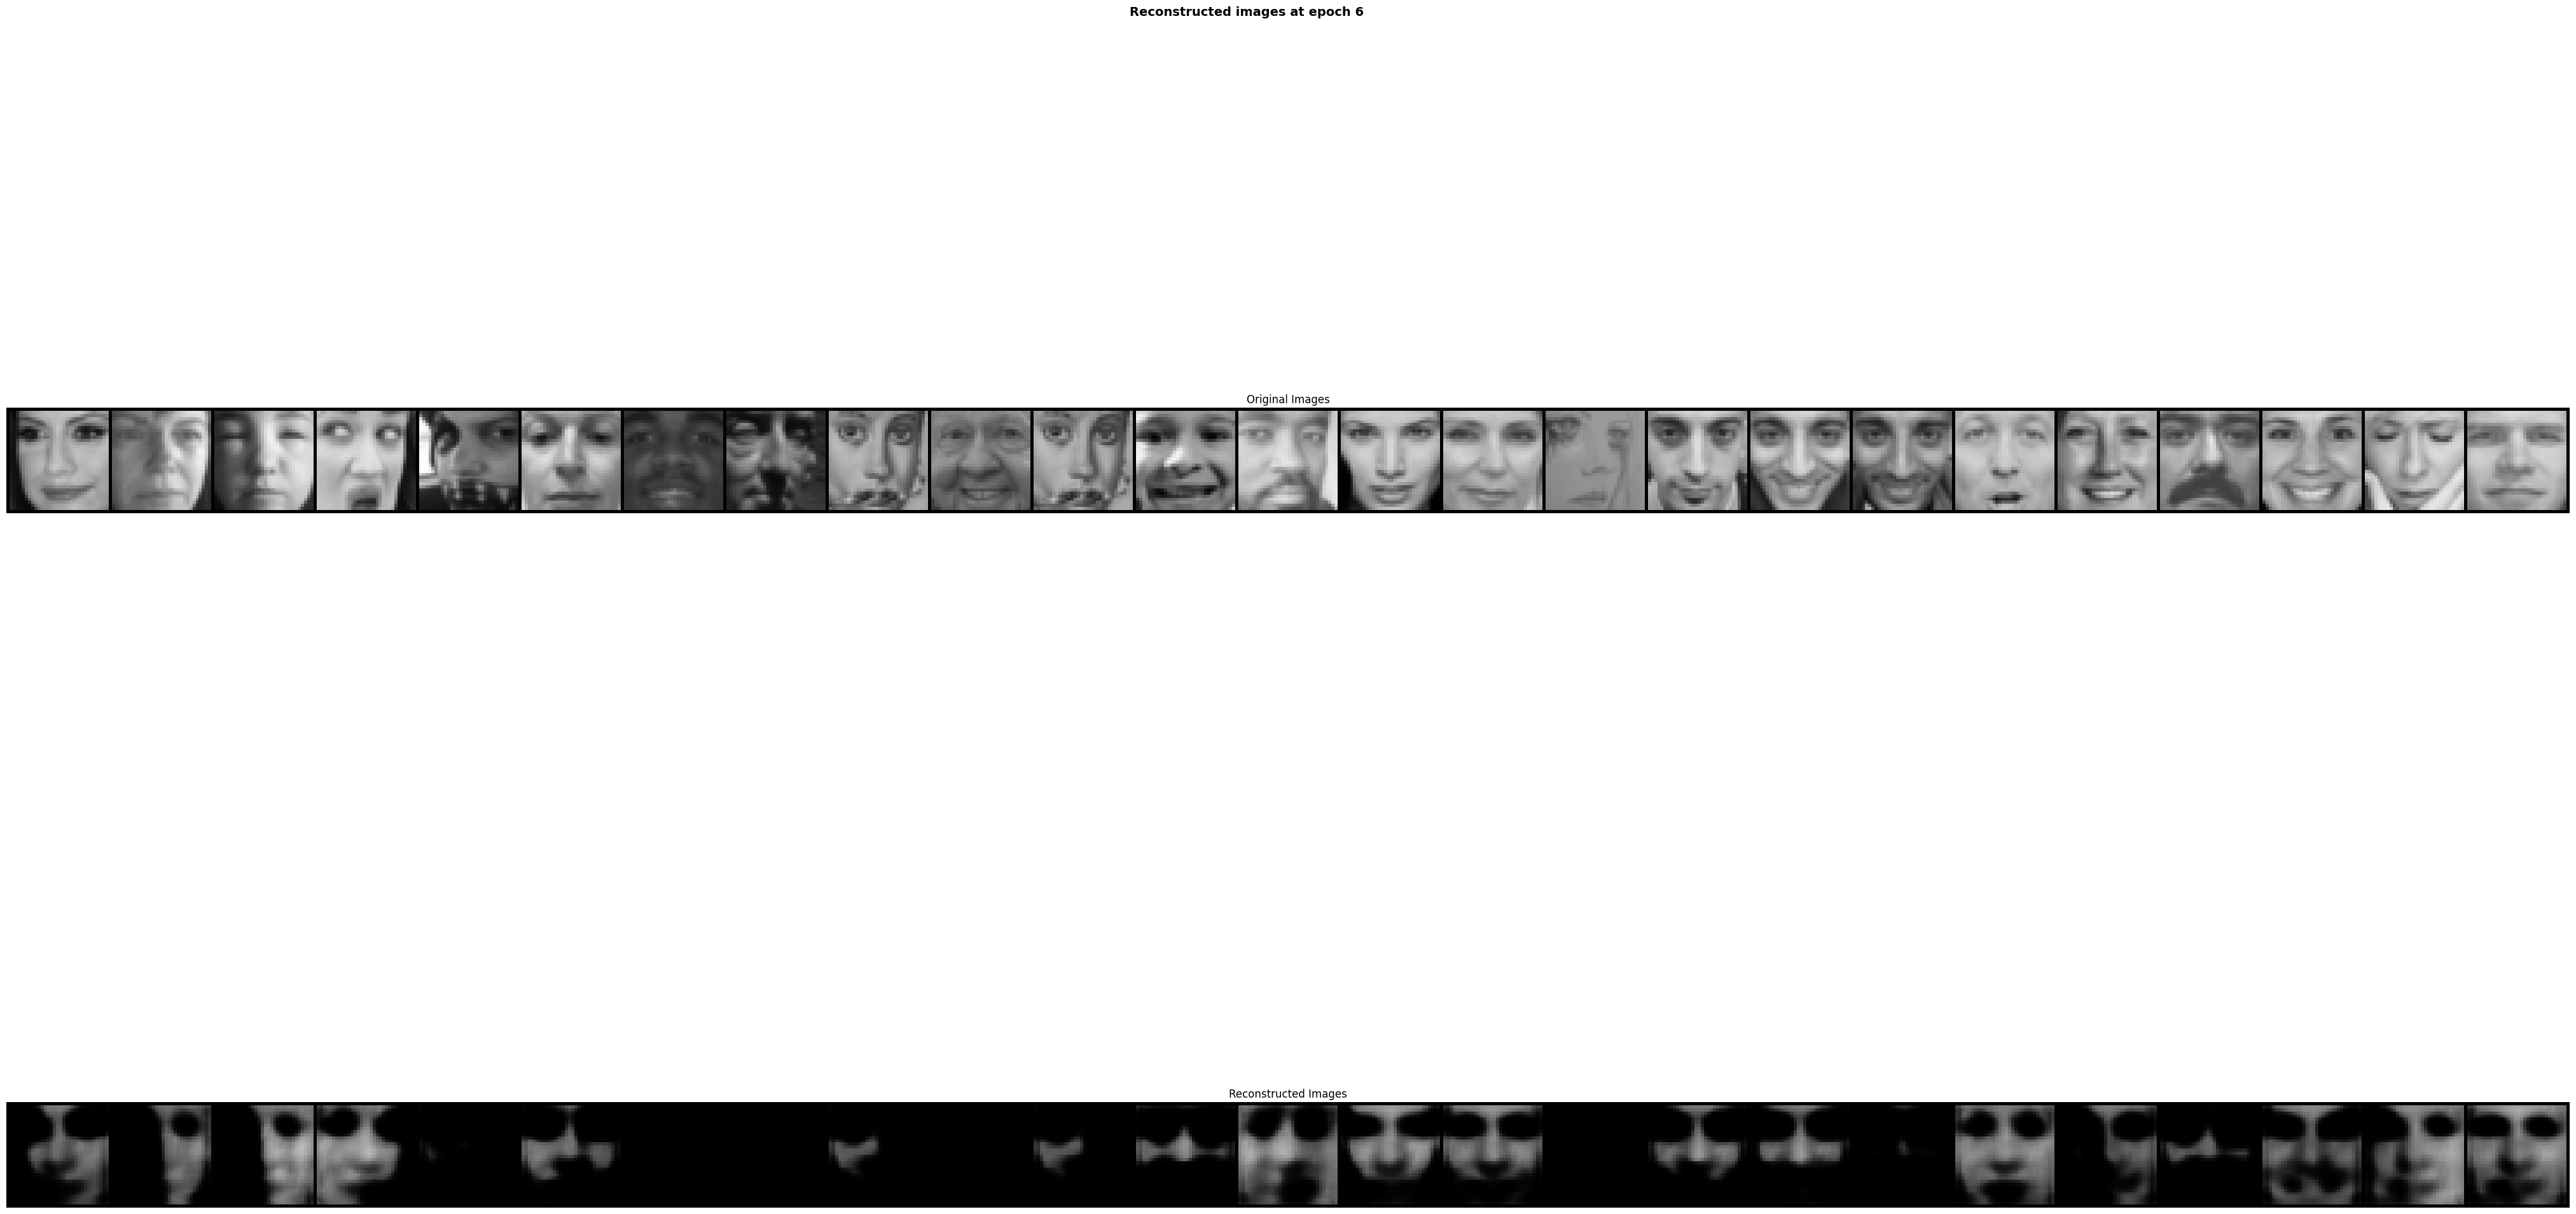

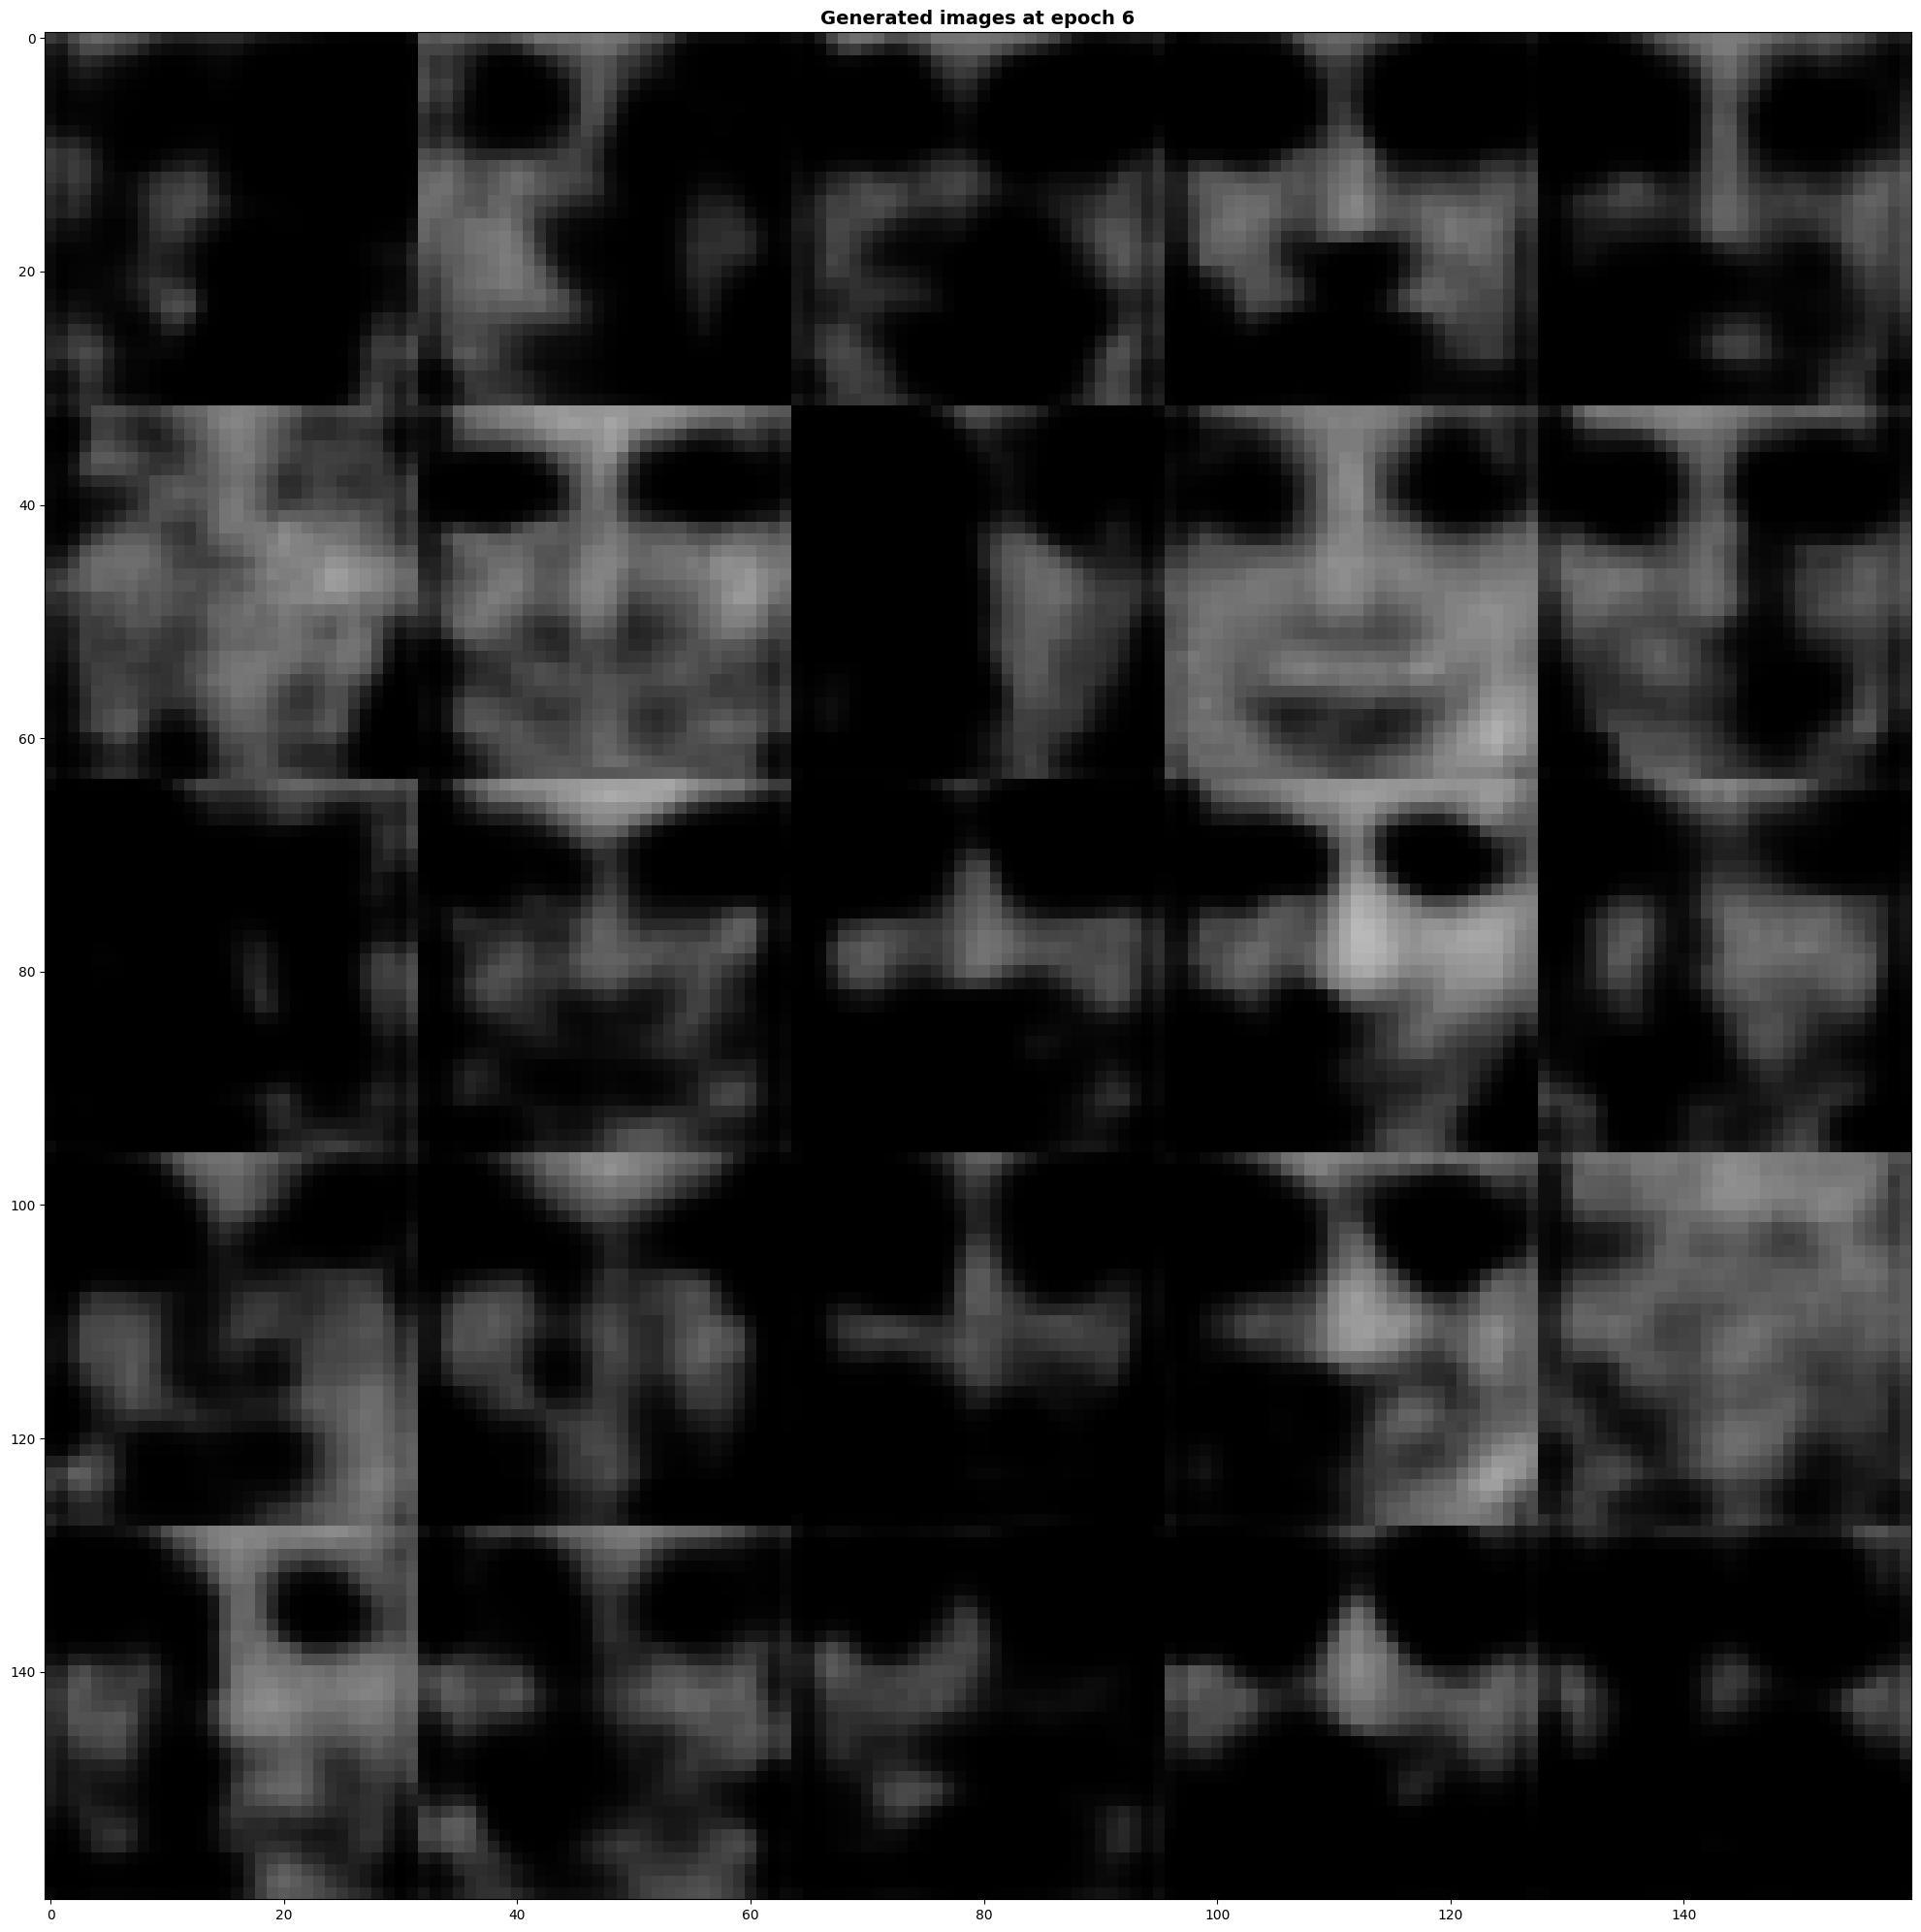

Epoch [6/10], Step [20/20], Rec. Loss: 0.0957, KL Loss: 9.3481
Epoch [7/10], Step [20/20], Rec. Loss: 0.0945, KL Loss: 9.3965


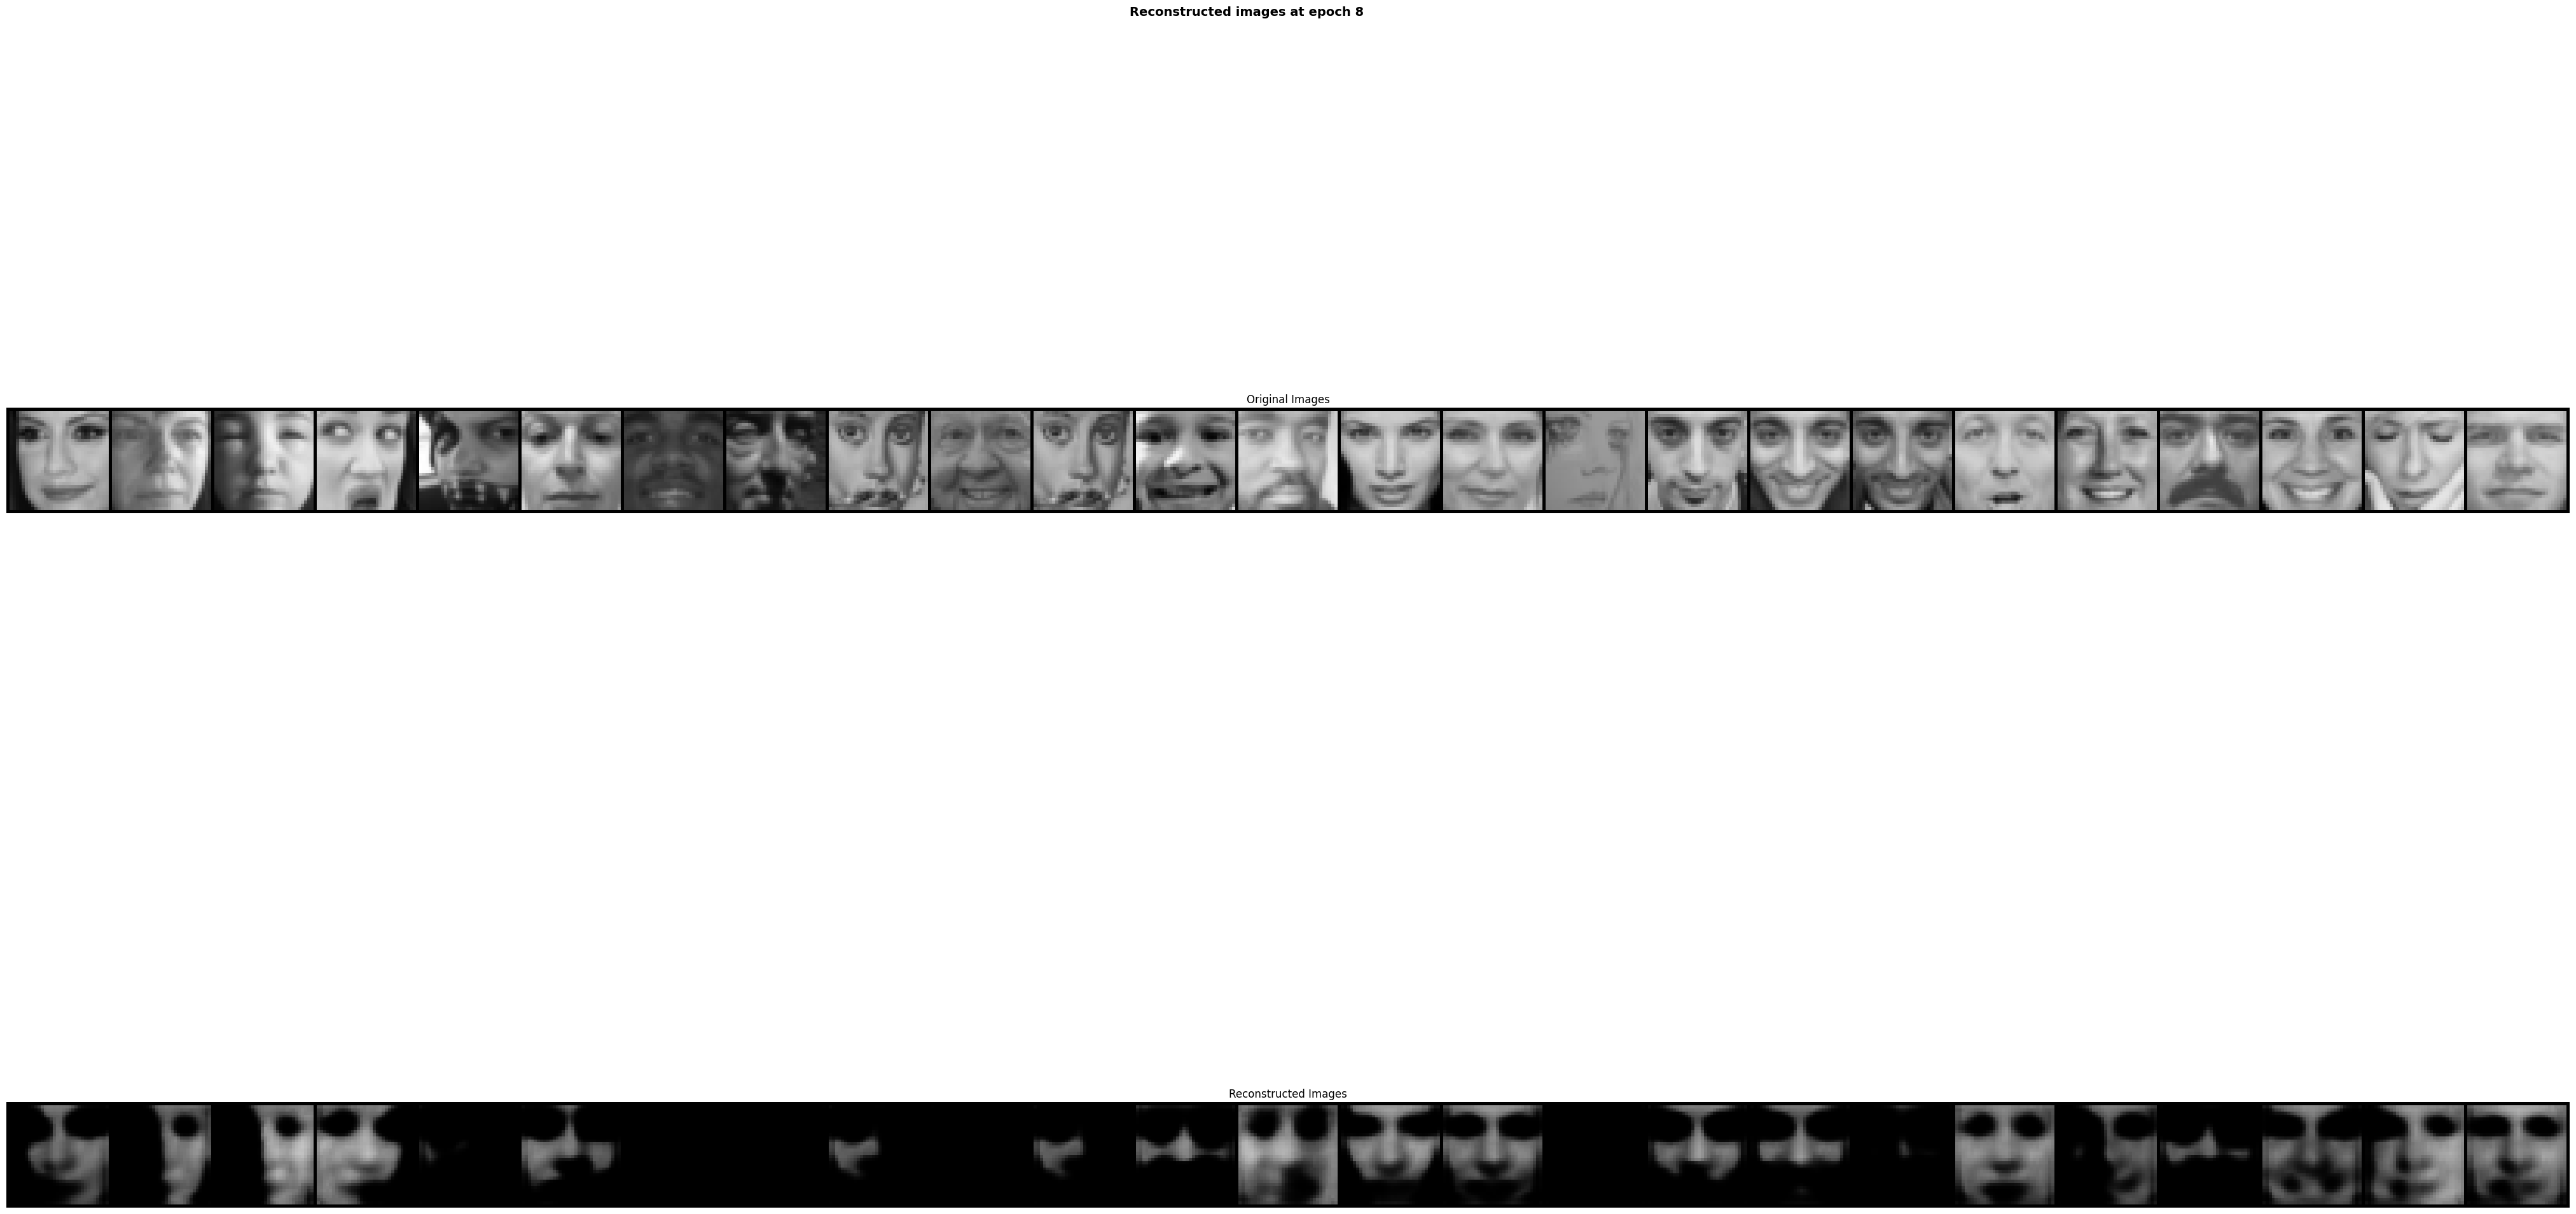

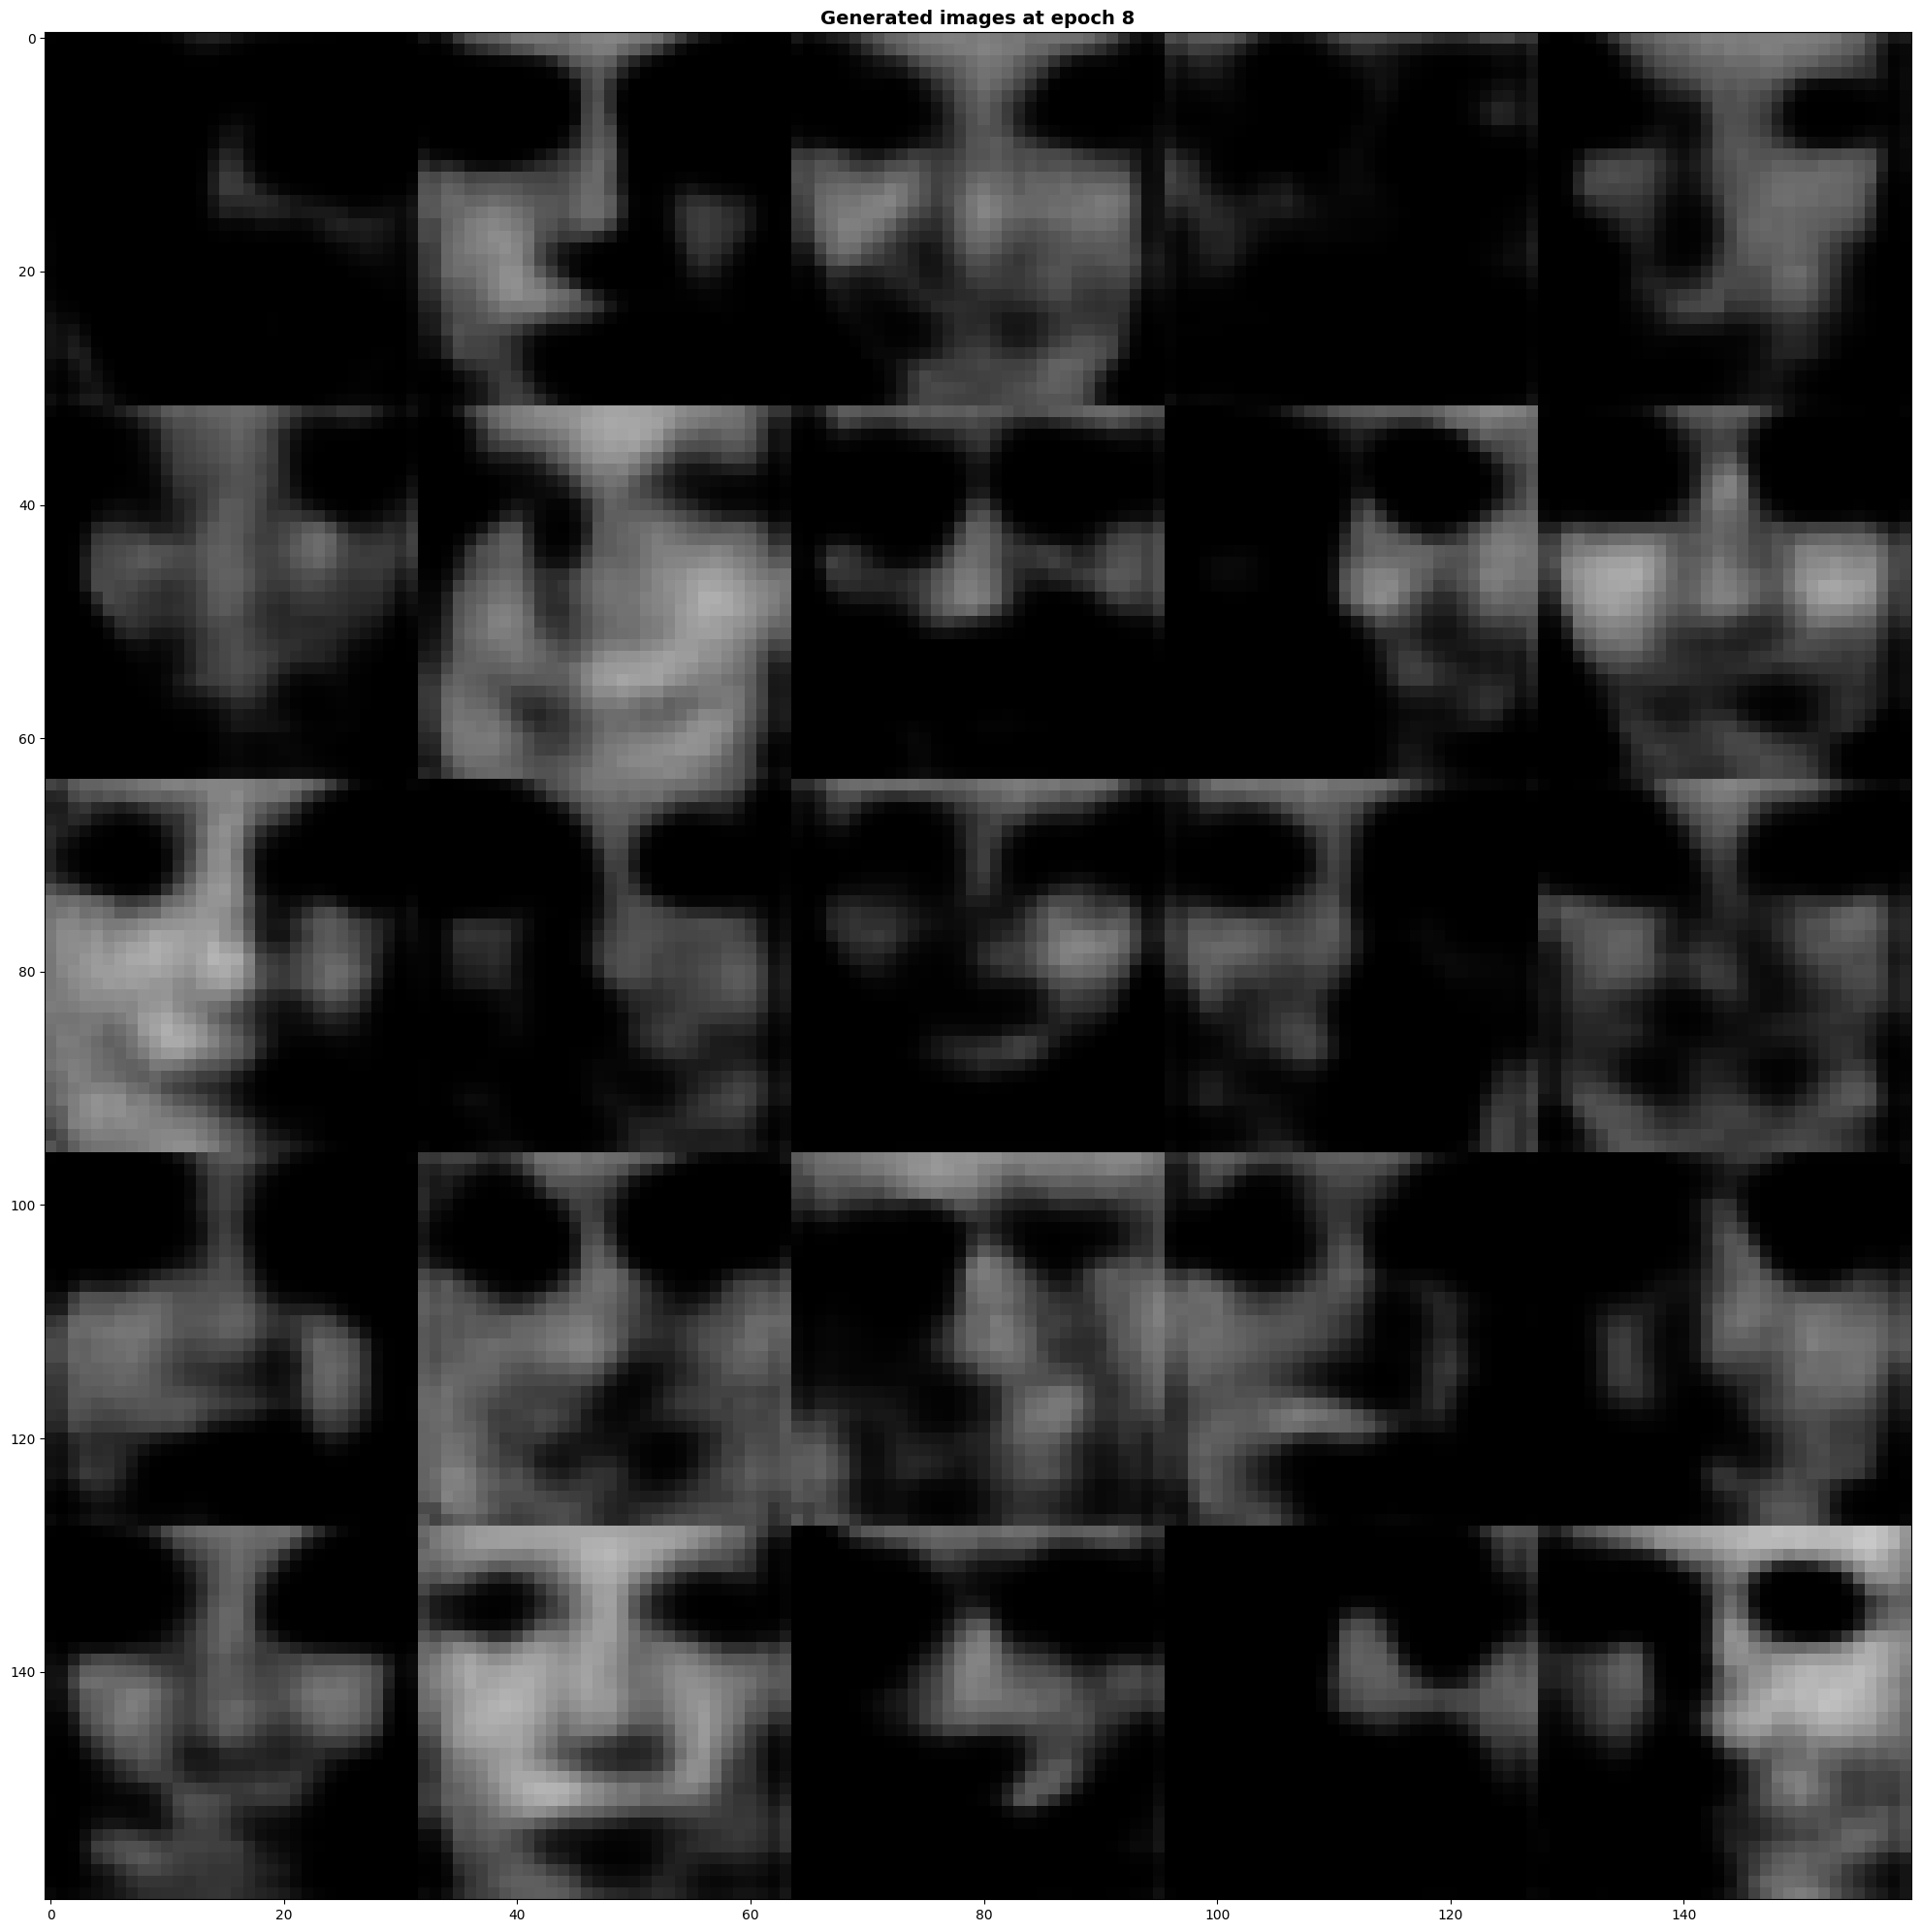

Epoch [8/10], Step [20/20], Rec. Loss: 0.0936, KL Loss: 9.2972
Epoch [9/10], Step [20/20], Rec. Loss: 0.0925, KL Loss: 9.2567


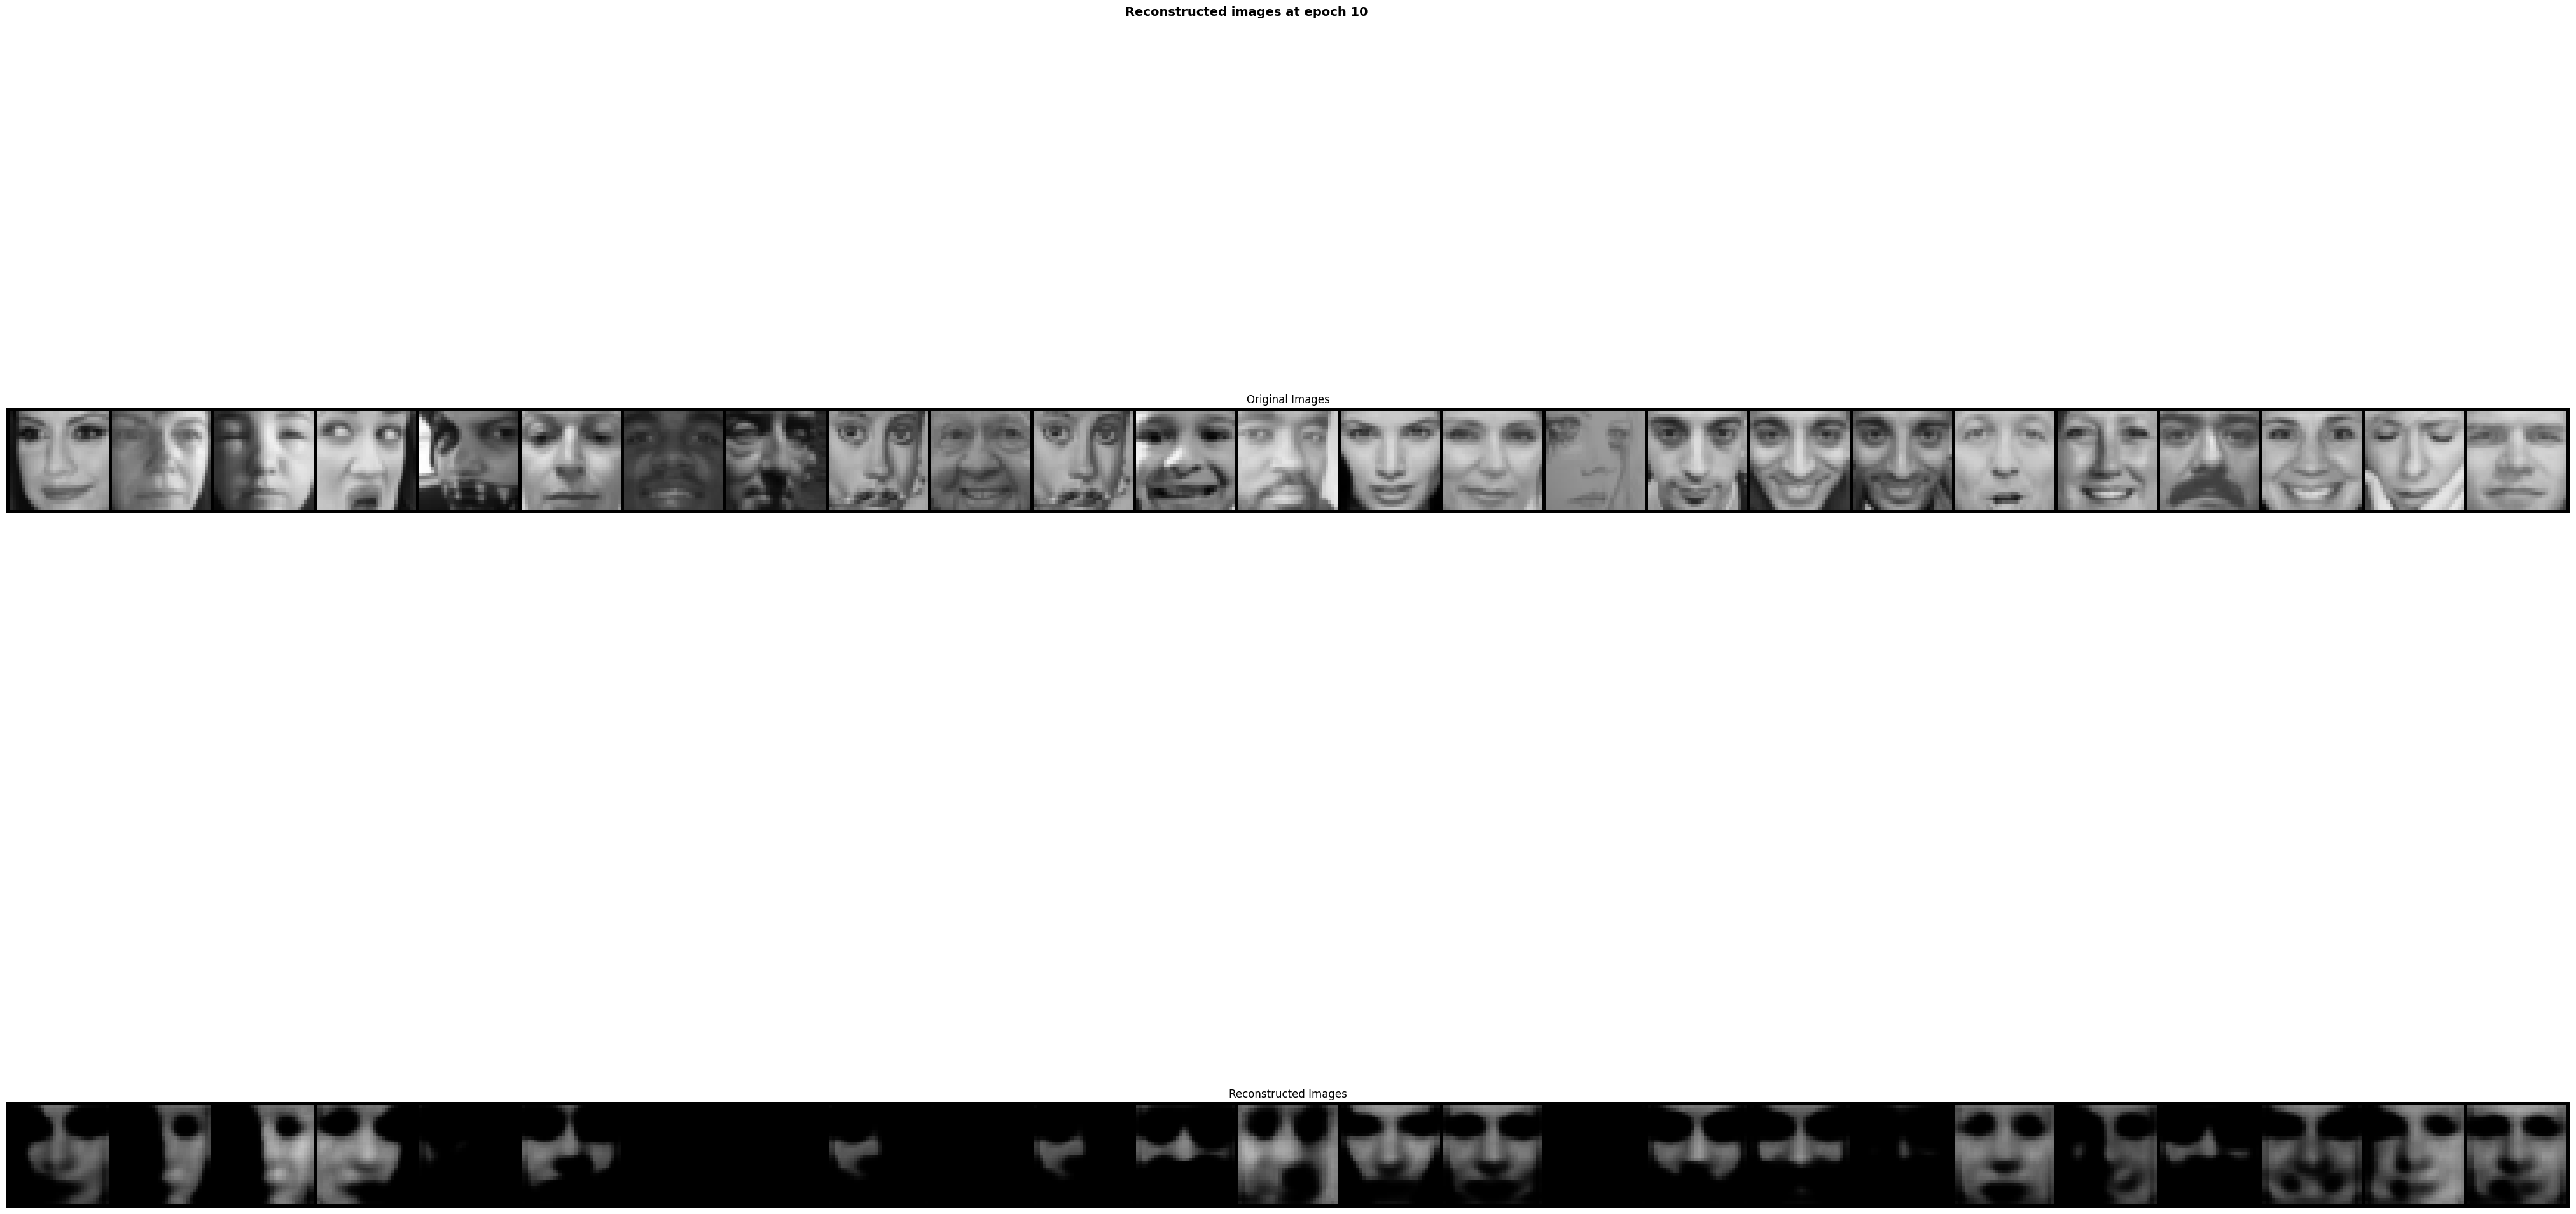

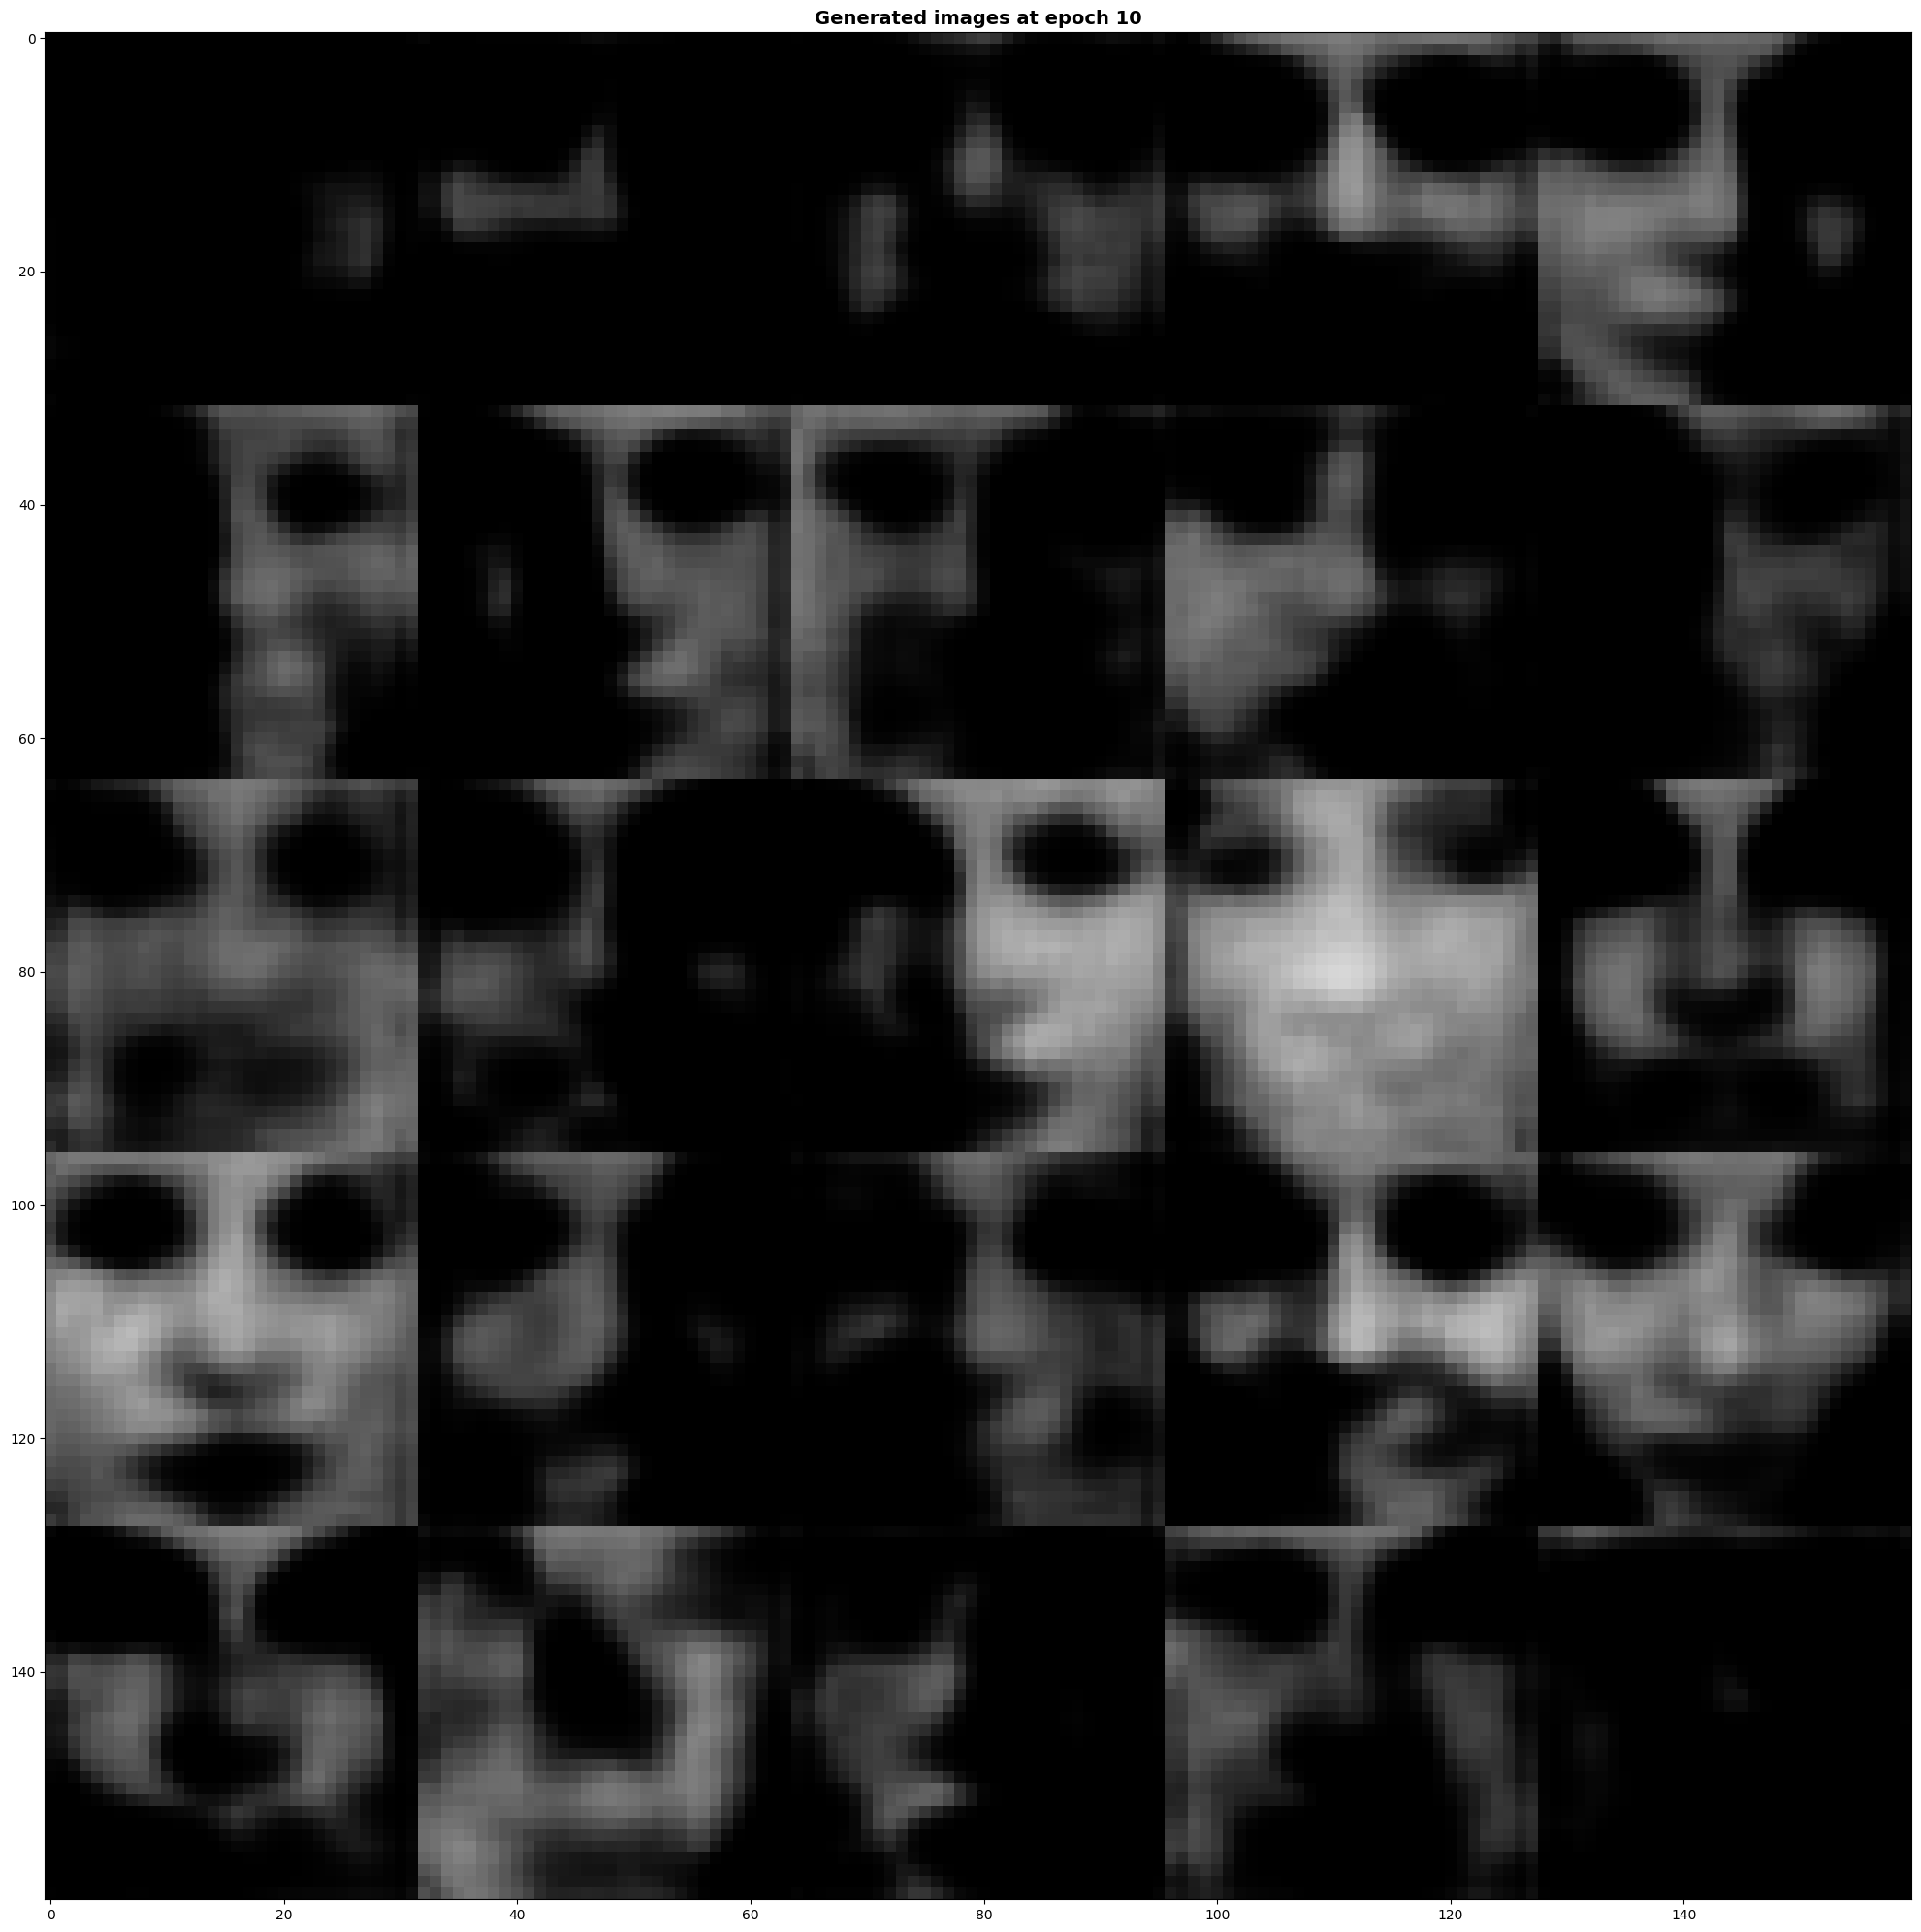

Epoch [10/10], Step [20/20], Rec. Loss: 0.0919, KL Loss: 9.1794


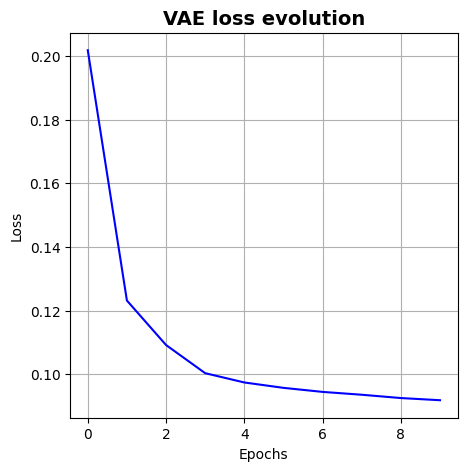

In [22]:
if train_vae:
    vae = VAE(out_features=output_resolution)
    kl_weight = 0.001
    learning_rate = .001
    # We use Adam optimizer which is tipically used in VAEs and GANs
    optimizer = torch.optim.Adam(vae.parameters(),lr = learning_rate, weight_decay=1e-5)

    print("#################### Training VAE ####################")
    loss_list = train_VAE(vae, train_loader, test_loader, optimizer, kl_weight=kl_weight,
                        num_epochs=num_epochs, device=device, plot_every=plot_every)

    figure = plt.figure(figsize=(5, 5))
    plt.title("VAE loss evolution", fontsize=14, fontweight="bold")
    plt.plot(loss_list, color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    if save_figure:
        plt.savefig(f"{results_path}/vae_loss_evolution.png", dpi=300)

    if not show_figure:
        plt.close()


# Ex. 2

1. Following the example of the MNIST , train a GAN with the images we have provided for the CK dataset.

2. For every two epochs during training:

    2.1. Generate and show a set of images from random noise z.

    2.2. Visualize a set of generated images by interpolating over the latent space z.

    2.3 Discuss the different visualizations by analysing their relation between their quality and the evolution of the discriminator and generator losses.

**Compare the results with the ones obtained with VAEs**.

In [23]:
class TrainController:
    def __init__(self, loss_threshold:float=0.01, train_gen_every:int=2) -> None:
        assert(train_gen_every >= 2)
        self.counter = 1
        self.train_gen_every = train_gen_every
        self.loss_threshold = loss_threshold

    def is_train_generator(self, disc_loss:float) -> bool:
        self.counter += 1
        return self.counter % self.train_gen_every == 0# or disc_loss < self.loss_threshold


In [24]:
# GAN Train function. We have a generator and discriminator models and their respective optimizers.
def train_GAN(gan: GAN, train_loader, optimizer_gen, optim_disc,
              num_epochs=10, device='cpu', plot_every=2):
    gan.train()
    gan = gan.to(device)

    total_step = len(train_loader)
    disc_losses_list = []
    gen_losses_list = []

    controller = TrainController(loss_threshold=0.05, train_gen_every=3)
    update_generator = False

    # Iterate over epochs
    for epoch in range(1, num_epochs + 1):
        # Iterate the dataset
        disc_loss_avg = 0
        gen_loss_avg = 0
        nBatches = 0

        for i, real_images in enumerate(train_loader):
            # Get batch of samples and labels
            real_images = real_images.to(device)
            n_images = real_images.shape[0]

            # Forward pass
            # Generate random images with the generator
            fake_images = gan.sample(n_images, device=device)

            # Use the discriminator to obtain the probabilties for real and generate imee
            prob_real = gan.discriminator(real_images)
            prob_fake = gan.discriminator(fake_images)

            # Generator loss
            gen_loss = -torch.log(prob_fake).mean()
            # Discriminator loss
            disc_loss = -0.5 * (torch.log(prob_real) + torch.log(1 - prob_fake)).mean()


            # We are going to update the discriminator and generator parameters alternatively at each iteration
            if update_generator:
                optimizer_gen.zero_grad()
                gen_loss.backward() # Necessary to not erase intermediate variables needed for computing disc_loss gradient
                optimizer_gen.step()
            else:
                optim_disc.zero_grad()
                disc_loss.backward()
                optimizer_disc.step()

            disc_loss_avg += disc_loss.cpu().item()
            gen_loss_avg += gen_loss.cpu().item()

            nBatches += 1
            # if (i+1) % 200 == 0:
            #     trained_module = "generator" if update_generator else "discriminator"
            #     print('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}, Trained module: {}'
            #            .format(epoch, num_epochs, i+1, total_step, gen_loss.cpu().item(), disc_loss.cpu().item(), trained_module))

        # Visualize the images every two training epochs
        if epoch % plot_every == 0:
            n_samples = num_val_images # NOTE: num_val_images is a global variable
            generate_images(gan, epoch, n_samples, device=device)
            generate_interpolated(gan, epoch, n_samples, device=device)

        # Print loss at the end of the epoch
        trained_module = "generator" if update_generator else "discriminator"
        print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}, Trained module: {}'
                       .format(epoch, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches, trained_module))

        # Decide whether to train the generator or the discriminator for the next epoch
        update_generator = controller.is_train_generator(disc_loss_avg / nBatches)

        # Save model
        disc_losses_list.append(disc_loss_avg / nBatches)
        gen_losses_list.append(gen_loss_avg / nBatches)
        torch.save(gan.state_dict(), f"{results_path}/{gan.name}_ck.ckpt")

    return disc_losses_list, gen_losses_list

In [29]:
# Train the model
if train_gan:
    # Define Geneartor and Discriminator networks
    gan = GAN(in_features=output_resolution)

    #Initialize indepdent optimizer for both networks
    learning_rate_gen = .0002
    learning_rate_disc = .0002 # FIXME: What about making the discriminator learn quicker
    optimizer_gen = torch.optim.Adam(gan.generator.parameters(), lr = learning_rate_gen, weight_decay=1e-5, betas=(0.5, 0.999))
    optimizer_disc = torch.optim.Adam(gan.discriminator.parameters(), lr = learning_rate_disc, weight_decay=1e-5, betas=(0.5, 0.999))

    print("\n\n#################### Training GAN ####################")
    # Train the GAN
    disc_loss_list, gen_loss_list = train_GAN(
        gan, train_loader, optimizer_gen, optimizer_disc,
        num_epochs=num_epochs, device=device, plot_every=plot_every
    )

    figure2 = plt.figure(figsize=(5, 5))
    plt.title("GAN loss evolution", fontsize=14, fontweight="bold")
    plt.plot(disc_loss_list, label="Discriminator loss", color="blue")
    plt.plot(gen_loss_list, label="Generator loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()

    if save_figure:
        plt.savefig(f"{results_path}/gan_loss_evolution.png", dpi=300)

    if not show_figure:
        plt.close()


if show_figure:
    plt.show()



#################### Training GAN ####################
Epoch [1/20], Step [20/20], Gen. Loss: 2.5013, Disc Loss: 0.1627, Trained module: discriminator
Epoch [2/20], Step [20/20], Gen. Loss: 4.3711, Disc Loss: 0.0166, Trained module: discriminator
Epoch [3/20], Step [20/20], Gen. Loss: 0.5981, Disc Loss: 1.2192, Trained module: generator
Epoch [4/20], Step [20/20], Gen. Loss: 4.3156, Disc Loss: 0.1504, Trained module: discriminator
Epoch [5/20], Step [20/20], Gen. Loss: 5.4226, Disc Loss: 0.0073, Trained module: discriminator
Epoch [6/20], Step [20/20], Gen. Loss: 0.6042, Disc Loss: 1.4342, Trained module: generator
Epoch [7/20], Step [20/20], Gen. Loss: 4.9857, Disc Loss: 0.1459, Trained module: discriminator
Epoch [8/20], Step [20/20], Gen. Loss: 5.7742, Disc Loss: 0.0070, Trained module: discriminator
Epoch [9/20], Step [20/20], Gen. Loss: 0.6490, Disc Loss: 1.3430, Trained module: generator


Epoch [10/20], Step [20/20], Gen. Loss: 5.3705, Disc Loss: 0.1317, Trained module: discriminator
Epoch [11/20], Step [20/20], Gen. Loss: 6.5906, Disc Loss: 0.0107, Trained module: discriminator
Epoch [12/20], Step [20/20], Gen. Loss: 0.4455, Disc Loss: 1.9847, Trained module: generator
Epoch [13/20], Step [20/20], Gen. Loss: 12.2590, Disc Loss: 0.1459, Trained module: discriminator
Epoch [14/20], Step [20/20], Gen. Loss: 11.7650, Disc Loss: 0.0028, Trained module: discriminator
Epoch [15/20], Step [20/20], Gen. Loss: 0.6483, Disc Loss: 1.6158, Trained module: generator
Epoch [16/20], Step [20/20], Gen. Loss: 12.6180, Disc Loss: 0.1317, Trained module: discriminator
Epoch [17/20], Step [20/20], Gen. Loss: 9.2110, Disc Loss: 0.0044, Trained module: discriminator
Epoch [18/20], Step [20/20], Gen. Loss: 0.6121, Disc Loss: 1.1525, Trained module: generator
Epoch [19/20], Step [20/20], Gen. Loss: 8.1225, Disc Loss: 0.1166, Trained module: discriminator


Epoch [20/20], Step [20/20], Gen. Loss: 6.4857, Disc Loss: 0.0091, Trained module: discriminator
